# CyClust test for extended winter 2011/2012

In [12]:
#Necessary libraries
#from geopy.distance import great_circle as great_circle_old
from datetime import datetime as dt, timedelta as td
import numpy as np
from numpy import loadtxt
import time
from timeit import default_timer as timer
import xarray as xr
import sparse
from scipy.sparse import dok_matrix

#Matplotlib
#import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm, dates, ticker, pyplot as plt

#%matplotlib inline
%matplotlib notebook

#Clustering functions
from Cluster_functions import unnest, calc_Rossby_radius, compare_trks_np, find_cluster, find_cluster_type, find_cluster_type2, find_cluster_type3, find_cluster_type_dokm, dist_along_track_np
import Cluster_functions

import shapely.geometry as sgeom
from ipywidgets import *

## Thresholds and options to use in this specific run
<div class="alert alert-block alert-info">
<b>Tip:</b> Use blue boxes (alert-info) for tips and notes. 
If it’s a note, you don’t have to include the word “Note”.
</div>

In [24]:
#########################
# Thresholds
#########################

#1. Distance criterium
distthresh = 1.0 #1000.0

#2. Time criterium
timthresh = 36.0

#3. Length/Time criterium 
lngthresh = 1.5 #1.5 #2.0 #calc_Rossby_radius(lat=45)*2.0 # 1000.0
timlngthresh = 6
minPairs = 24

# Options
timmeth = "absolute"
timspace = False #Use a combined Time-Space criterium 
connTime = False #Connect on lengths
connSpaceTime = False
connSpaceOrTime = True
connPairs = False
excludeLong = False #Exclude other type
distmeth = "AlongTracksDirect" #"MaxDist" #"AlongTracks" "AlongTrackDirect"
frameworkSparse = True #True


# Output directory
outdir = "Results/"

# Minimum of nr. of storms in a "family"
minstorms = 3

st_file = "Selected_tracks_2011_2012"

## Load Storm tracks

In [25]:
nrskip = 0
str_id   = loadtxt(st_file, comments="#", unpack=False,skiprows=nrskip,usecols=[0],dtype=int)
str_nr   = loadtxt(st_file, comments="#", unpack=False,skiprows=nrskip,usecols=[1],dtype=int)
str_date = loadtxt(st_file, comments="#", unpack=False,skiprows=nrskip,usecols=[2],dtype=int)
str_lat  = loadtxt(st_file, comments="#", unpack=False,skiprows=nrskip,usecols=[4])
str_lon  = loadtxt(st_file, comments="#", unpack=False,skiprows=nrskip,usecols=[3])
str_result = "Results_DJF_NH_2011_2012_"

#Determine datetime array for the tracks
str_dt = []
str_hour = np.zeros(len(str_date))
str_day = np.zeros(len(str_date))
str_month = np.zeros(len(str_date))
str_year = np.zeros(len(str_date))
for idx in range(len(str_date)):
	year = int(str(str_date[idx])[:4])
	month = int(str(str_date[idx])[4:6])
	day   = int(str(str_date[idx])[6:8])
	hour   = int(str(str_date[idx])[8:10])
	str_hour[idx] = hour
	str_day[idx] = day
	str_month[idx] = month
	str_year[idx] = year
	str_dt.append(dt(year,month,day,hour))

#Convert to an array
str_dt          = np.array(str_dt)
str_connected   = np.zeros(str_dt.shape)
str_id = str_id - np.nanmin(str_id) + 1

nrstorms = len(np.unique(str_id))

## Pre-process storm track data

In [26]:
#Check which year, month, hemisphere belongs storms to
start = time.time()
wintstrms = np.zeros(nrstorms)
yrstorms = np.zeros(nrstorms)
mnstorms = np.zeros(nrstorms)
hemstorms = np.full(nrstorms,"Undefined")
firstdt = []
lastdt = []

uniq_ids = np.unique(str_id)

for strid in range(nrstorms):
    
	dt_temp = str_dt[str_id == uniq_ids[strid]]
	lat_temp = str_lat[str_id == uniq_ids[strid]]

	#Check which winter it belongs to
	tmpyear = dt_temp[0].year
	tmpmonth = dt_temp[0].month
	yrstorms[strid] = tmpyear
	mnstorms[strid] = tmpmonth

	if(tmpmonth < 11):
		tmpyear = tmpyear - 1
	wintstrms[strid] = tmpyear

	#Save the first and last dt
	firstdt.append(dt_temp[0])
	lastdt.append(dt_temp[-1])

	#Check if the storm is in the NH or SH
	if(np.nanmean(lat_temp) > 0):
		hemstorms[strid] = "NH"
	elif(np.nanmean(lat_temp) < 0):
		hemstorms[strid] = "SH"

end = time.time()
firstdt = np.array(firstdt)
lastdt = np.array(lastdt)
print(start-end)

#Months of storm, relative to beginning of 1979
mnstorms_rel = (yrstorms - 1979)*12.0 + mnstorms
refdt = dt(1979,1,1,0,0)
diffs = [(x - refdt).total_seconds()/3600 for x in str_dt]          

-0.03625297546386719


## Determine cyclone clusters/families

In [45]:
print("---------------------------------------------")
print("Start checking for:                          ")
print("Distance threshold = " + str(distthresh))
print("Time threshold = " + str(timthresh))
print("Length threshold = " + str(lngthresh))
print("---------------------------------------------")

timthresh_dt = td(hours=timthresh)

######################################################
# Find connected and clustered storms
#######################################################
if(frameworkSparse == False):
    connTracks = np.zeros([np.nanmax(str_id),np.nanmax(str_id)])
    angleTracks = np.zeros([np.nanmax(str_id),np.nanmax(str_id)])
    drTracks  = np.zeros([np.nanmax(str_id),np.nanmax(str_id)])
    dtTracks = np.zeros([np.nanmax(str_id),np.nanmax(str_id)])
else:
    connTracks = dok_matrix((np.nanmax(str_id),np.nanmax(str_id)))
    angleTracks = dok_matrix((np.nanmax(str_id),np.nanmax(str_id)))
    drTracks  = dok_matrix((np.nanmax(str_id),np.nanmax(str_id)))
    dtTracks = dok_matrix((np.nanmax(str_id),np.nanmax(str_id)))
    #connTracks = sparse.DOK((np.nanmax(str_id),np.nanmax(str_id)))
    #angleTracks = sparse.DOK((np.nanmax(str_id),np.nanmax(str_id)))
    #drTracks  = sparse.DOK((np.nanmax(str_id),np.nanmax(str_id)))
    #dtTracks = sparse.DOK((np.nanmax(str_id),np.nanmax(str_id)))
    
maxdists = []
maxdistsown = []
angles = []
anglesClust = []
clusterTypes = []
clusterTypes2 = []
angleTypes = []

starttime = timer()
for strm1 in range(nrstorms): #range(nrstorms): #[1]: # #range(6500,7000): # 
    #print("Strm1 :" + str(uniq_ids[strm1]))
    selidxs1 = np.where(str_id == uniq_ids[strm1])
    lats1 = str_lat[selidxs1]	
    #print(lats1)
    lons1 = str_lon[selidxs1]
    times1 = str_dt[selidxs1]
    
    #Only check if the storm is in the current month, or one after or before it, in the same hemisphere. 
    #diffmon = mnstorms_rel[strm1] - mnstorms_rel
    diffdt1  = firstdt - lastdt[strm1]
    diffdt2  = firstdt[strm1] - lastdt
    
    #strm2idxs = np.where( (np.abs(diffmon) <= 1) & (hemstorms == hemstorms[strm1]))[0]
    strm2idxs = np.where((np.arange(nrstorms) > strm1) & ((diffdt1 <= timthresh_dt) & (diffdt2 <= timthresh_dt)) & (hemstorms == hemstorms[strm1]))[0]
    #print("Nr strm2: " + str(len(strm2idxs)))
    
    for strm2 in strm2idxs: #[5]: #strm2idxs: #range(minstidx,maxstidx)
        #print("Strm1 :" + str(strm1 + 1) + " Strm2: " + str(strm2 + 1))

        selidxs2 = np.where(str_id == uniq_ids[strm2])
        lats2 = str_lat[selidxs2]
        lons2 = str_lon[selidxs2] 
        times2 = str_dt[selidxs2]
        #print(lats2)

        if(timmeth == "median"): 
            dists, timdiffs, = compare_trks_median(lons2,lats2,times2,lons1,lats1,times1,medians)
        elif(timmeth == "absolute"):
            dists, timdiffs, timspacediff  = compare_trks_np(lons2,lats2,times2,lons1,lats1,times1,timthresh) #,timthresh timspacediff,

        if(timspace == True):
            #Calculate distance over which storms are connected
            #First select just the lons, lats times over which a particular storm is connected
            pntselect = np.nanmax((timspacediff < 1.0),axis=0) #*Rossby_45
            test1 = np.nansum(pntselect) 
            #Do the same for the other track
            pntselect2 = np.nanmax((timspacediff < 1.0),axis=1) #*Rossby_45
            test2 = np.nansum(pntselect2)       
        else:
            #Calculate distance over which storms are connected
            #First select just the lons, lats times over which a particular storm is connected
            pntselect = np.nanmax((np.abs(timdiffs) <= timthresh) & (dists <= distthresh),axis=0) #*Rossby_45
            test1 = np.nansum(pntselect) 
            #Do the same for the other track
            pntselect2 = np.nanmax((np.abs(timdiffs) <= timthresh) & (dists <= distthresh),axis=1) #*Rossby_45
            test2 = np.nansum(pntselect2)
            
            nrPairs = np.nansum((np.abs(timdiffs) <= timthresh) & (dists <= distthresh))
            #print(nrPairs)

        if((test1 >=2) & (test2 >= 2)):
            pntdists, pnttimdiffs, = compare_trks_np(lons1[pntselect],lats1[pntselect],times1[pntselect],lons2[pntselect2],lats2[pntselect2],times2[pntselect2])

            #Just select the points which are connected and calculate distances between the points for both tracks
            owndists, owntims, = compare_trks_np(lons1[pntselect],lats1[pntselect],times1[pntselect],lons1[pntselect],lats1[pntselect],times1[pntselect])
            owndists2, owntims2, = compare_trks_np(lons2[pntselect2],lats2[pntselect2],times2[pntselect2],lons2[pntselect2],lats2[pntselect2],times2[pntselect2])
            
            maxdist = (np.nanmax(owndists) + np.nanmax(owndists2))/2.0
            maxtime = (np.nanmax(np.abs(owntims)) + np.nanmax(np.abs(owntims2)))/2.0
            #maxtime = (test1 + test2)/2.0*6.0

            maxtimspacediff = ((maxdist/lngthresh)**2.0 + (maxtime/(timlngthresh*6.0))**2.0)**(0.5)
            
            ratio = (maxtime/(timlngthresh*6.0))/(maxdist/lngthresh)
            angle = np.arctan(ratio)
            
            
            if(maxtimspacediff >=1.0):
                #print("Max distance: " + str(maxdist))
                #print("Max time diff: " + str(maxtime))
                #print("Max spacetime diff: " + str(maxtimspacediff))
            

                #print("Angle: " + str(angle*180/np.pi))
                #print("Ratio: " + str(ratio))
            
                angles.extend([angle*180/np.pi])
        else:
            maxdist = 0
            maxtime = 0
            maxtimspacediff = 0
        
        if(connSpaceOrTime == True):
            if((maxtime > (timlngthresh*6.0)) or (maxdist >= lngthresh)):
                if(maxtime > (timlngthresh*6.0)):
                    connTracks[strm1,strm2] = connTracks[strm1,strm2] + 2
                    connTracks[strm2,strm1] = connTracks[strm2,strm1] + 2
                    
                if(maxdist >= lngthresh):
                    connTracks[strm1,strm2] = connTracks[strm1,strm2] + 1
                    connTracks[strm2,strm1] = connTracks[strm2,strm1] + 1   
                                
                str_contemp1 = str_connected[selidxs1]
                str_contemp1[pntselect] = 1.0
                str_contemp2 = str_connected[selidxs2]
                str_contemp2[pntselect2] = 1.0
                str_connected[selidxs1] = str_contemp1
                str_connected[selidxs2] = str_contemp2  

                anglesClust.extend([angle*180/np.pi])
                angleTracks[strm1,strm2] = angle*180/np.pi
                
                if(angle == 0):
                    print("Zero angle")
                    print((maxdist/lngthresh))
                    print((maxtime/(timlngthresh*6.0)))

                drTracks[strm1,strm2] = (maxdist/lngthresh)
                dtTracks[strm1,strm2] = (maxtime/(timlngthresh*6.0))
            else:
                anglesClust.extend([np.nan])
        elif(connSpaceTime == True):
            if(maxtimspacediff > 1.0):
                connTracks[strm1,strm2] = 1
                connTracks[strm2,strm1] = 1
                str_contemp1 = str_connected[selidxs1]
                str_contemp1[pntselect] = 1.0
                str_contemp2 = str_connected[selidxs2]
                str_contemp2[pntselect2] = 1.0
                str_connected[selidxs1] = str_contemp1
                str_connected[selidxs2] = str_contemp2  

                anglesClust.extend([angle*180/np.pi])
                angleTracks[strm1,strm2] = angle*180/np.pi

                drTracks[strm1,strm2] = (maxdist/lngthresh)
                dtTracks[strm1,strm2] = (maxtime/(timlngthresh*6.0))
            else:
                anglesClust.extend([np.nan])
        elif(connPairs == True):        
                if(nrPairs>= minPairs):
                    connTracks[strm1,strm2] = 1
                    connTracks[strm2,strm1] = 1
                    str_contemp1 = str_connected[selidxs1]
                    str_contemp1[pntselect] = 1.0
                    str_contemp2 = str_connected[selidxs2]
                    str_contemp2[pntselect2] = 1.0
                    str_connected[selidxs1] = str_contemp1
                    str_connected[selidxs2] = str_contemp2 
                    anglesClust.extend([angle*180/np.pi])
                    angleTracks[strm1,strm2] = angle*180/np.pi
                    
                    print(maxdist)
        elif(connTime & (test1 >=2) & (test2 >= 2)):
            if(distmeth == "MaxDist"):
                pntdists, pnttimdiffs, = compare_trks_np(lons1[pntselect],lats1[pntselect],times1[pntselect],lons2[pntselect2],lats2[pntselect2],times2[pntselect2])
                maxdist = np.nanmax(pntdists)
            elif(distmeth == "AlongTracksDirect"):
                #Just select the points which are connected and calculate distances between the points for both tracks
                owndists, owntims, = compare_trks_np(lons1[pntselect],lats1[pntselect],times1[pntselect],lons1[pntselect],lats1[pntselect],times1[pntselect])
                owndists2, owntims2, = compare_trks_np(lons2[pntselect2],lats2[pntselect2],times2[pntselect2],lons2[pntselect2],lats2[pntselect2],times2[pntselect2])
            
                maxdist = (np.nanmax(owndists) + np.nanmax(owndists2))/2.0
            elif(distmeth == "AlongTracks"):
                alongdists1, totaldist1 = dist_along_track_np(lons1[pntselect],lats1[pntselect])
                alongdists2, totaldist2 = dist_along_track_np(lons2[pntselect2],lats2[pntselect2])
                maxdist = (totaldist1 + totaldist2)/2.0
            else:
                raise ValueError("Max dist has not the right value")
            
            #Check if long tracks should be excluded
            TestLength = True
            if(excludeLong == True):
                if(maxdist >= lngthresh):
                    TestLength = False
            
            if((test1 >= timlngthresh) & (test2 >= timlngthresh) & TestLength):
                connTracks[strm1,strm2] = 1
                connTracks[strm2,strm1] = 1
                str_contemp1 = str_connected[selidxs1]
                str_contemp1[pntselect] = 1.0
                str_contemp2 = str_connected[selidxs2]
                str_contemp2[pntselect2] = 1.0
                str_connected[selidxs1] = str_contemp1
                str_connected[selidxs2] = str_contemp2           
        #If both are connected over at least two points, check the maximum distance
        elif((test1 >=2) & (test2 >= 2)):
            
            avelat = np.nanmean(np.append(lats1[pntselect],lats2[pntselect2]))
            #corrfac = np.abs(calc_Rossby_radius(lat=avelat)/calc_Rossby_radius(lat=45))
            #maxdist = (np.nanmax(owndists) + np.nanmax(owndists2))/2.0
                     
            #print("Maxdist: " + str((np.nanmax(owndists) + np.nanmax(owndists2))/2.0))
            #print("Maxdist (other method:): " + str(np.nanmax(pntdists)))
            #print("Maxdist (along first track:): " + str(totaldist1))
            #print("Maxdist (along second track:): " + str(totaldist2))
            
            if(distmeth == "MaxDist"):
                pntdists, pnttimdiffs, = compare_trks_np(lons1[pntselect],lats1[pntselect],times1[pntselect],lons2[pntselect2],lats2[pntselect2],times2[pntselect2])
                maxdist = np.nanmax(pntdists)
            elif(distmeth == "AlongTracksDirect"):
                #Just select the points which are connected and calculate distances between the points for both tracks
                owndists, owntims, = compare_trks_np(lons1[pntselect],lats1[pntselect],times1[pntselect],lons1[pntselect],lats1[pntselect],times1[pntselect])
                owndists2, owntims2, = compare_trks_np(lons2[pntselect2],lats2[pntselect2],times2[pntselect2],lons2[pntselect2],lats2[pntselect2],times2[pntselect2])
            
                maxdist = (np.nanmax(owndists) + np.nanmax(owndists2))/2.0
            elif(distmeth == "AlongTracks"):
                alongdists1, totaldist1 = dist_along_track_np(lons1[pntselect],lats1[pntselect])
                alongdists2, totaldist2 = dist_along_track_np(lons2[pntselect2],lats2[pntselect2])
                maxdist = (totaldist1 + totaldist2)/2.0
            else:
                raise ValueError("Max dist has not the right value")
            
            maxdists.append(maxdist)
            if(strm1 == strm2):
                maxdistsown.append(maxdist)
                
            #print("Strm2: " + str(strm2 + 1) + " Max dist: " + str(maxdist) + " Trck1: " + str(np.nanmax(owndists)) + " Trck2: " + str(np.nanmax(owndists2)))
                
            if(maxdist >= lngthresh): #*Rossby_45*corrfac
                #print("Strm2: " + str(strm2 + 1) + " Max dist: " + str(maxdist) + " Trck1: " + str(np.nanmax(owndists)) + " Trck2: " + str(np.nanmax(owndists2)))
                connTracks[strm1,strm2] = 1
                connTracks[strm2,strm1] = 1
                str_contemp1 = str_connected[selidxs1]
                str_contemp1[pntselect] = 1.0 
                str_contemp2 = str_connected[selidxs2]
                str_contemp2[pntselect2] = 1.0

                #Save connected points
                str_connected[selidxs1] = str_contemp1
                str_connected[selidxs2] = str_contemp2
                
    
                
endtime = timer()
print(endtime - starttime) # Time in seconds, e.g. 5.38091952400282
timing = endtime -starttime
#np.fill_diagonal(connTracks,0)

if(frameworkSparse == True):
    connTracks = connTracks.tocsr()

########################
# Step 2 Find clusters
########################
clusters = []
maxlength = 1

for stridx in range(nrstorms):
    #print(stridx)
    if(frameworkSparse == True):
        clusttemp = find_cluster_type_dokm([stridx],connTracks)        
    else:
        clusttemp, connTypes, clusterType = find_cluster_type([stridx],connTracks) 
    #clusttemp2, connTypes2, anglesClust2, clusterType2, angleType = find_cluster_type2([stridx],connTracks, angleTracks)
    
    #if(clusterType != clusterType2):
    #    print(connTypes)
    #    print(clusterType)
    #    print(connTypes2)
    #    print(clusterType2)
    
    if(len(clusttemp) > maxlength):
        maxlength = len(clusttemp)
    
    clusttemp = [uniq_ids[x] for x in clusttemp] #Convert indices to storm id
    clusters.append(clusttemp)
    #clusterTypes.append(clusterType)
    #clusterTypes2.append(clusterType2)
    #angleTypes.append(angleType)
    
    
#Delete duplicates and sort on the first number in clusters:
unique_clusters = [list(x) for x in set(tuple(x) for x in clusters)]

#from operator import itemgetter
sorted_clusters =  sorted(unique_clusters)
print(timer() - starttime) # Time in seconds, e.g. 5.38091952400282

############################
# Step 3 Suborder clusters
############################
sorted_subclusters_length = []
sorted_subclusters_nolength = []

for cluster in sorted_clusters:
    #print(stridx)
    subclusters_length = []
    subclusters_nolength = []
    
    for stridx in cluster:
        
        #Length clusters
        if(frameworkSparse == True):
            clusttemp = find_cluster_type_dokm([stridx - 1],connTracks,contype="Length")
        else:
            clusttemp, connTypes, clusterType = find_cluster_type3([stridx - 1],connTracks,contype="Length")


        clusttemp = [uniq_ids[x] for x in clusttemp] #Convert indices to storm id
        subclusters_length.append(clusttemp)
        
        #Stationary clusters
        if(frameworkSparse == True):
            clusttemp = find_cluster_type_dokm([stridx - 1],connTracks,contype="NoLength")
        else:
            clusttemp, connTypes, clusterType = find_cluster_type3([stridx - 1],connTracks,contype="NoLength") 

        clusttemp = [uniq_ids[x] for x in clusttemp] #Convert indices to storm id
        subclusters_nolength.append(clusttemp)
        
    #Delete duplicates and sort on the first number in (sub)clusters:
    unique_subclusters = [list(x) for x in set(tuple(x) for x in subclusters_length)]
    sorted_subclusters_length.append(sorted(unique_subclusters))
    
    #Delete duplicates and sort on the first number in (sub)clusters:
    unique_subclusters = [list(x) for x in set(tuple(x) for x in subclusters_nolength)]
    sorted_subclusters_nolength.append(sorted(unique_subclusters))
    
sorted_clusters_length = sorted(unnest(sorted_subclusters_length))
sorted_clusters_nolength = sorted(unnest(sorted_subclusters_nolength))
#sorted_clusters = sorted_clusters_length

---------------------------------------------
Start checking for:                          
Distance threshold = 1.0
Time threshold = 36.0
Length threshold = 1.5
---------------------------------------------
3.263155139000446
3.8882180319997133


In [7]:
#find_cluster_type3([99],connTracks,connType="Length")
find_cluster_type_dokm([stridx],connTracks)

array([0, 6])

In [254]:
#sorted_subclusters_nolength = sorted_subclusters
#sorted_subclusters_nolength

In [19]:
sparse_length = sorted_subclusters_length
sparse_nolength = sorted_subclusters_nolength
sparse_all = sorted_clusters

In [256]:
print("Clustered cyclones based on length: " + str(np.nansum(np.array(clusterTypes) == 'Length')))
print("Clustered cyclones based on time: " + str(np.nansum(np.array(clusterTypes) == 'Time')))
print("Clustered cyclones based on mixed: " + str(np.nansum(np.array(clusterTypes) == 'Mixed')))

print("Clustered cyclones based on length: " + str(np.nansum(np.array(clusterTypes2) == 'Length')))
print("Clustered cyclones based on time: " + str(np.nansum(np.array(clusterTypes2) == 'Time')))
print("Clustered cyclones based on mixed: " + str(np.nansum(np.array(clusterTypes2) == 'Mixed')))

print("Length: " + str(np.nansum(connTracks == 1.0)))
print("Time: " + str(np.nansum(connTracks == 2.0)))
print("Mixed: " + str(np.nansum(connTracks == 3.0)))

Clustered cyclones based on length: 15
Clustered cyclones based on time: 112
Clustered cyclones based on mixed: 33
Clustered cyclones based on length: 6
Clustered cyclones based on time: 31
Clustered cyclones based on mixed: 123
Length: 26
Time: 106
Mixed: 114


## Plots (3d and example)

In [257]:
#########################
# Subset Atlantic
#########################
selstrid = []
for strid in range(nrstorms):
        #tmp_date = str_date[str_id == strid + 1]
        #tmp_yrs  =  (tmp_date - tmp_date % 1000000)/1000000
        #tmp_mnts =  ((tmp_date - tmp_date % 10000)/10000)%100
        tmp_lons = str_lon[str_id == uniq_ids[strid]]
        tmp_lats = str_lat[str_id == uniq_ids[strid]]

        if((np.any(((tmp_lons > 280) | (tmp_lons < 40) )& (tmp_lats < 75))) ):
                selstrid.append(strid)

subset = connTracks[selstrid,:][:,selstrid]

#selclusters = np.array(sorted_clusters)[np.array(selstrid) - 1]
#selclusters =  [list(x) for x in set(tuple(x) for x in selclusters)]

###########################################
# Differentiate clusters and solo storms
###########################################
plotclusters    = []
plotnonclusters = []
plotstrms       = []
plotclststrms   = []
for x in set(tuple(x) for x in sorted_clusters):
    if(len(x) >= minstorms):
        plotclusters.append(list(x))
        plotclststrms.extend(list(x))
    else:
        plotnonclusters.append(list(x))
        plotstrms.extend(list(x))        

#ncmask, landmask, maskgrid = dynlib.metio.metopen("ei.ans.land-sea",q="lsm")

<IPython.core.display.Javascript object>


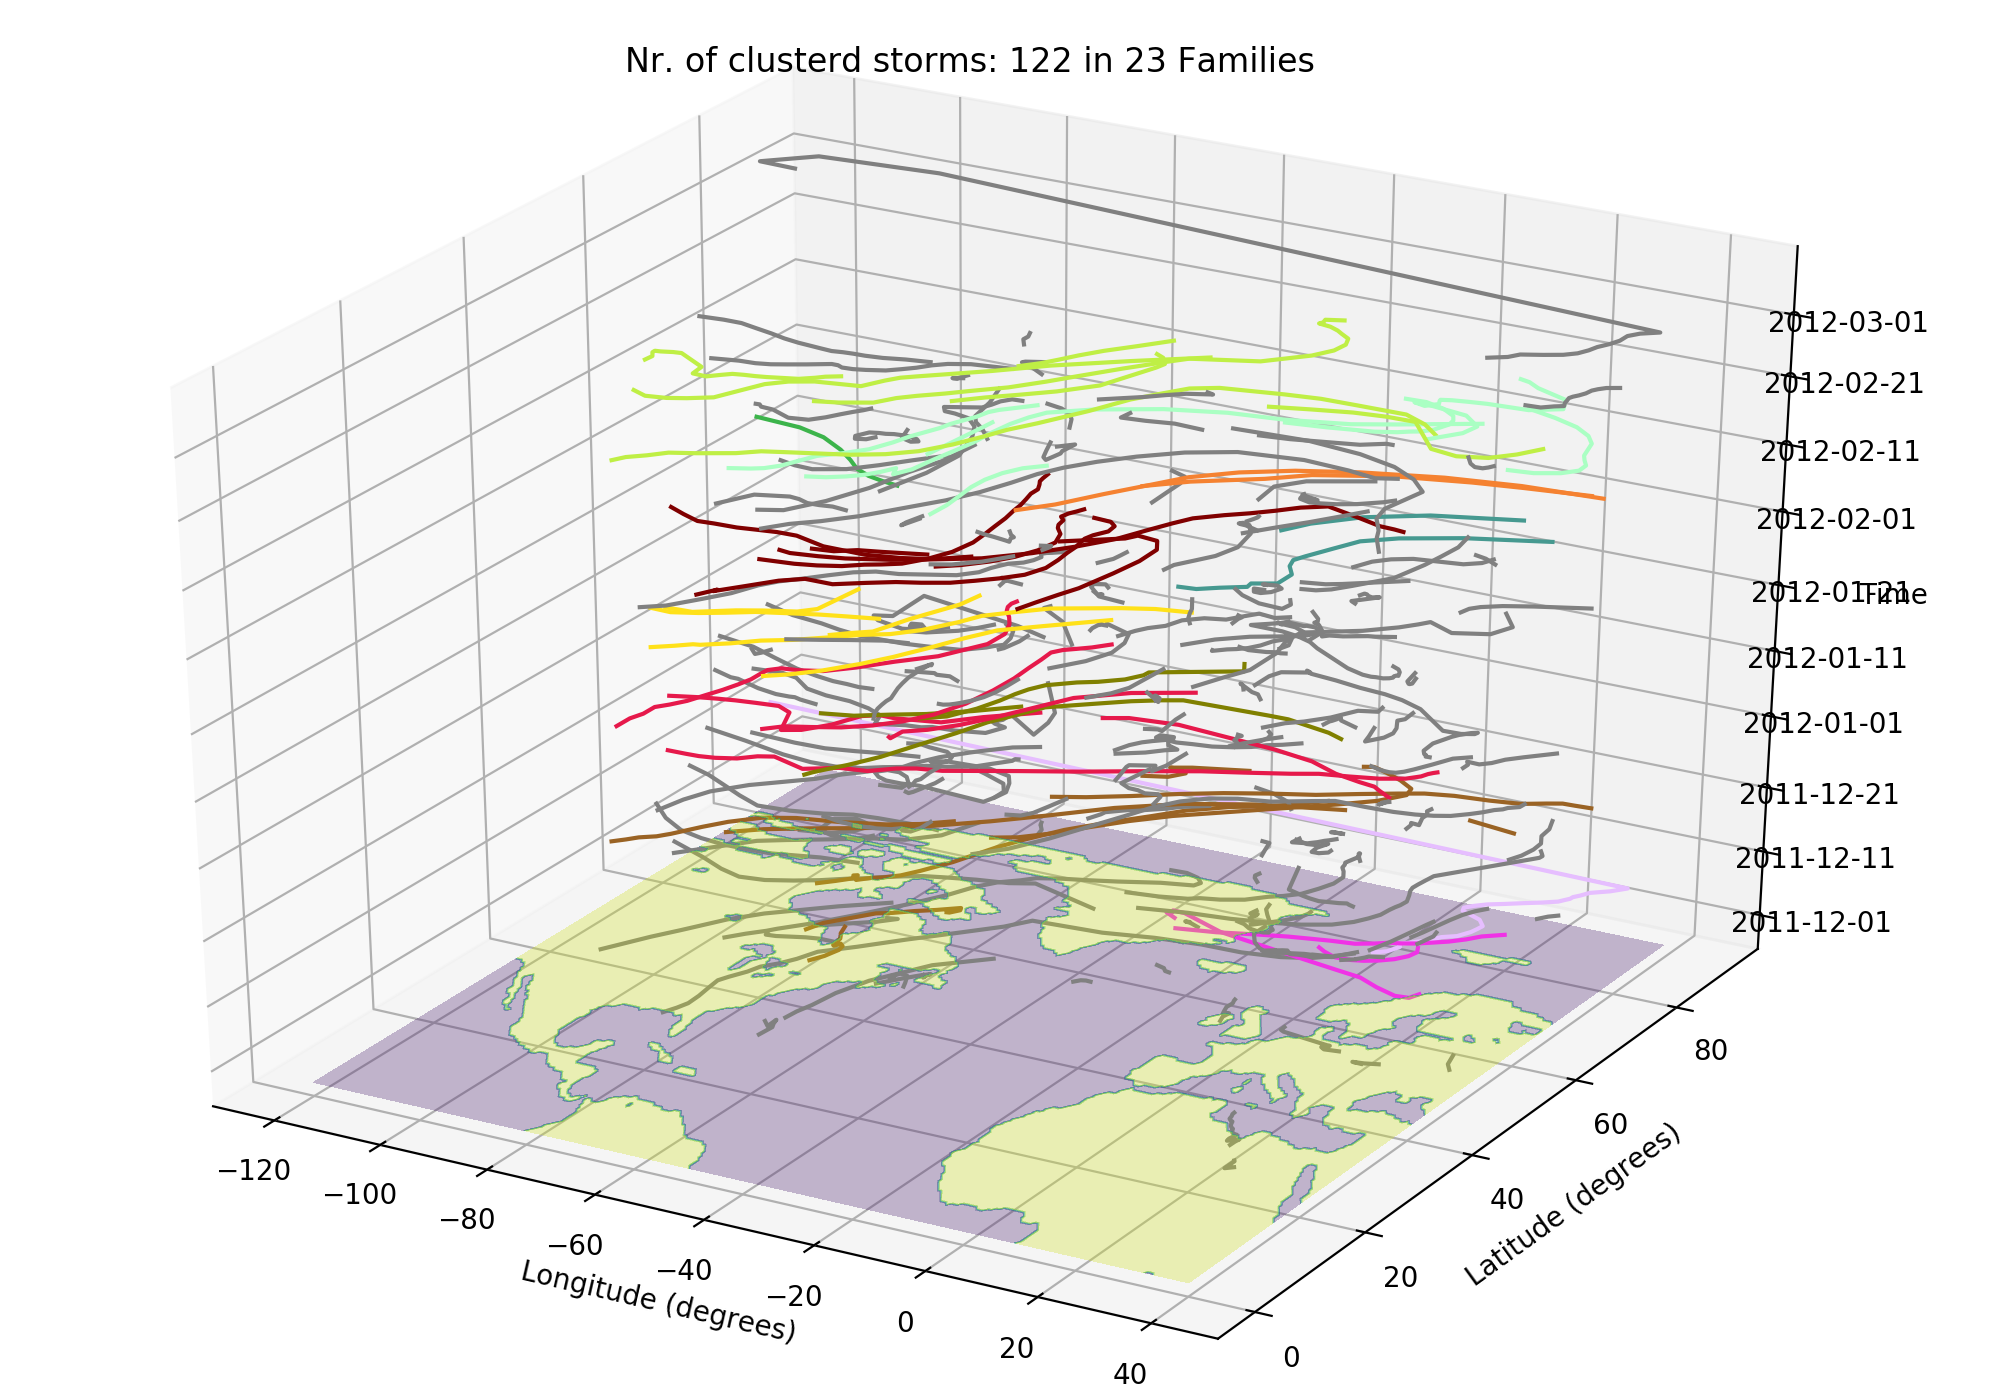

In [258]:
################################
# Plot Tracks of 2011/12 winter
################################
# matplotlib date format object
%matplotlib notebook
hfmt = dates.DateFormatter('%m/%d %H:%M')

def format_date(x, pos=None):
    return dates.num2date(x).strftime('%Y-%m-%d') #use FuncFormatter to format dates

#Min/Max longitude and latitude used in plots
lon_min = -120
lon_max = 40
lat_min = 0
lat_max = 90
        
# Load landmask data
ds = xr.open_dataset("ei.ans.land-sea.nc")
ds = ds.sel(longitude=slice(lon_min,lon_max),latitude=slice(lat_max,lat_min))

fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection="3d")

tmp_dt = str_dt[str_id == uniq_ids[0]]
firstdt = dates.date2num(tmp_dt)[0] # converted
lastdt = dates.date2num(str_dt[-1])
#firstdt = dates.date2num(dt(yr1,12,1))

colclust = ["red","dodgerblue","Darkgreen","Orange","Purple","Brown","Yellow","lightblue"]
colclust = ["#e6194B", "#3cb44b", "#ffe119", "#4363d8", "#f58231", "#911eb4", "#42d4f4", "#f032e6", "#bfef45", "#fabebe", "#469990", "#e6beff", "#9A6324", "#fffac8", "#800000", "#aaffc3", "#808000", "#ffd8b1", "#000075", "#000000"] #, #a9a9a9, #ffffff, 

atl_clust = 0
atl_nonclust = 0

for strid in selstrid:
        tmp_dt = str_dt[str_id == uniq_ids[strid]]
        tmp_datefloat = dates.date2num(tmp_dt) #-firstdt # converted
        tmp_lon = str_lon[str_id == uniq_ids[strid]]
        tmp_lon[tmp_lon > 180] = tmp_lon[tmp_lon > 180] - 360.0
        tmp_lat = str_lat[str_id == uniq_ids[strid]]
        #print("Storm " + str(strid))
        #print(tmp_lon)
        #print(tmp_lat)

        #Delete points outside data range
        if(np.any(tmp_lon > 40) ):
                delidxs = np.where(tmp_lon > 40)
                tmp_lon = np.delete(tmp_lon,delidxs)
                tmp_lat = np.delete(tmp_lat,delidxs)
                tmp_datefloat = np.delete(tmp_datefloat,delidxs)
                tmp_dt = np.delete(tmp_dt,delidxs)

        if(np.any(tmp_lon < - 120) ):
                delidxs = np.where(tmp_lon < -120)
                tmp_lon = np.delete(tmp_lon,delidxs)
                tmp_lat = np.delete(tmp_lat,delidxs)
                tmp_datefloat = np.delete(tmp_datefloat,delidxs)
                tmp_dt = np.delete(tmp_dt,delidxs)

        if( uniq_ids[strid] in plotstrms):            
                col = "gray"
                atl_nonclust += 1
        else:
                colidx = np.where([uniq_ids[strid] in x for x in plotclusters])[0]
                colidx = colidx%len(colclust)

                col = colclust[colidx[0]]
                atl_clust += 1

        ax.plot3D(tmp_lon, tmp_lat, tmp_datefloat, col,linewidth=1.5)
        #if(angleTypes[strid] == "Length"):
        #    ax.scatter3D(tmp_lon, tmp_lat, tmp_datefloat, c="Blue");
        #elif(angleTypes[strid] == "Time"):
        #    ax.scatter3D(tmp_lon, tmp_lat, tmp_datefloat, c='Red');
            
#3D mask at bottom of land-sea
lon = ds.coords['longitude'].values 
lat = ds.coords['latitude'].values
lon2d = np.tile(lon,(len(lat),1))
lat2d = np.tile(lat,(len(lon),1)).transpose()
#, time = ds.indexes.values()

cset = ax.contourf(lon2d,lat2d,
                   ds['lsm'].data.squeeze(),offset=firstdt,
                  alpha=0.3) #lon_mask, lat_mask, val_mask

#Change z-axis formatting to dates
ax.zaxis.set_major_locator(dates.DayLocator([1,11,21]))
ax.zaxis.set_major_formatter(ticker.FuncFormatter(format_date))
#ax.set_zlim(firstdt,734570.75)
ax.set_zlim(firstdt,lastdt)

plt.subplots_adjust(left=-0.03,right=1.0,bottom=-0.02,top=1.02)
plt.xlabel("Longitude (degrees)")
plt.ylabel("Latitude (degrees)")
ax.set_zlabel("Time")
plt.title("Nr. of clusterd storms: " + str(len(plotclststrms)) + " in " + str(len(plotclusters)) + " Families")

plt.show()

<IPython.core.display.Javascript object>


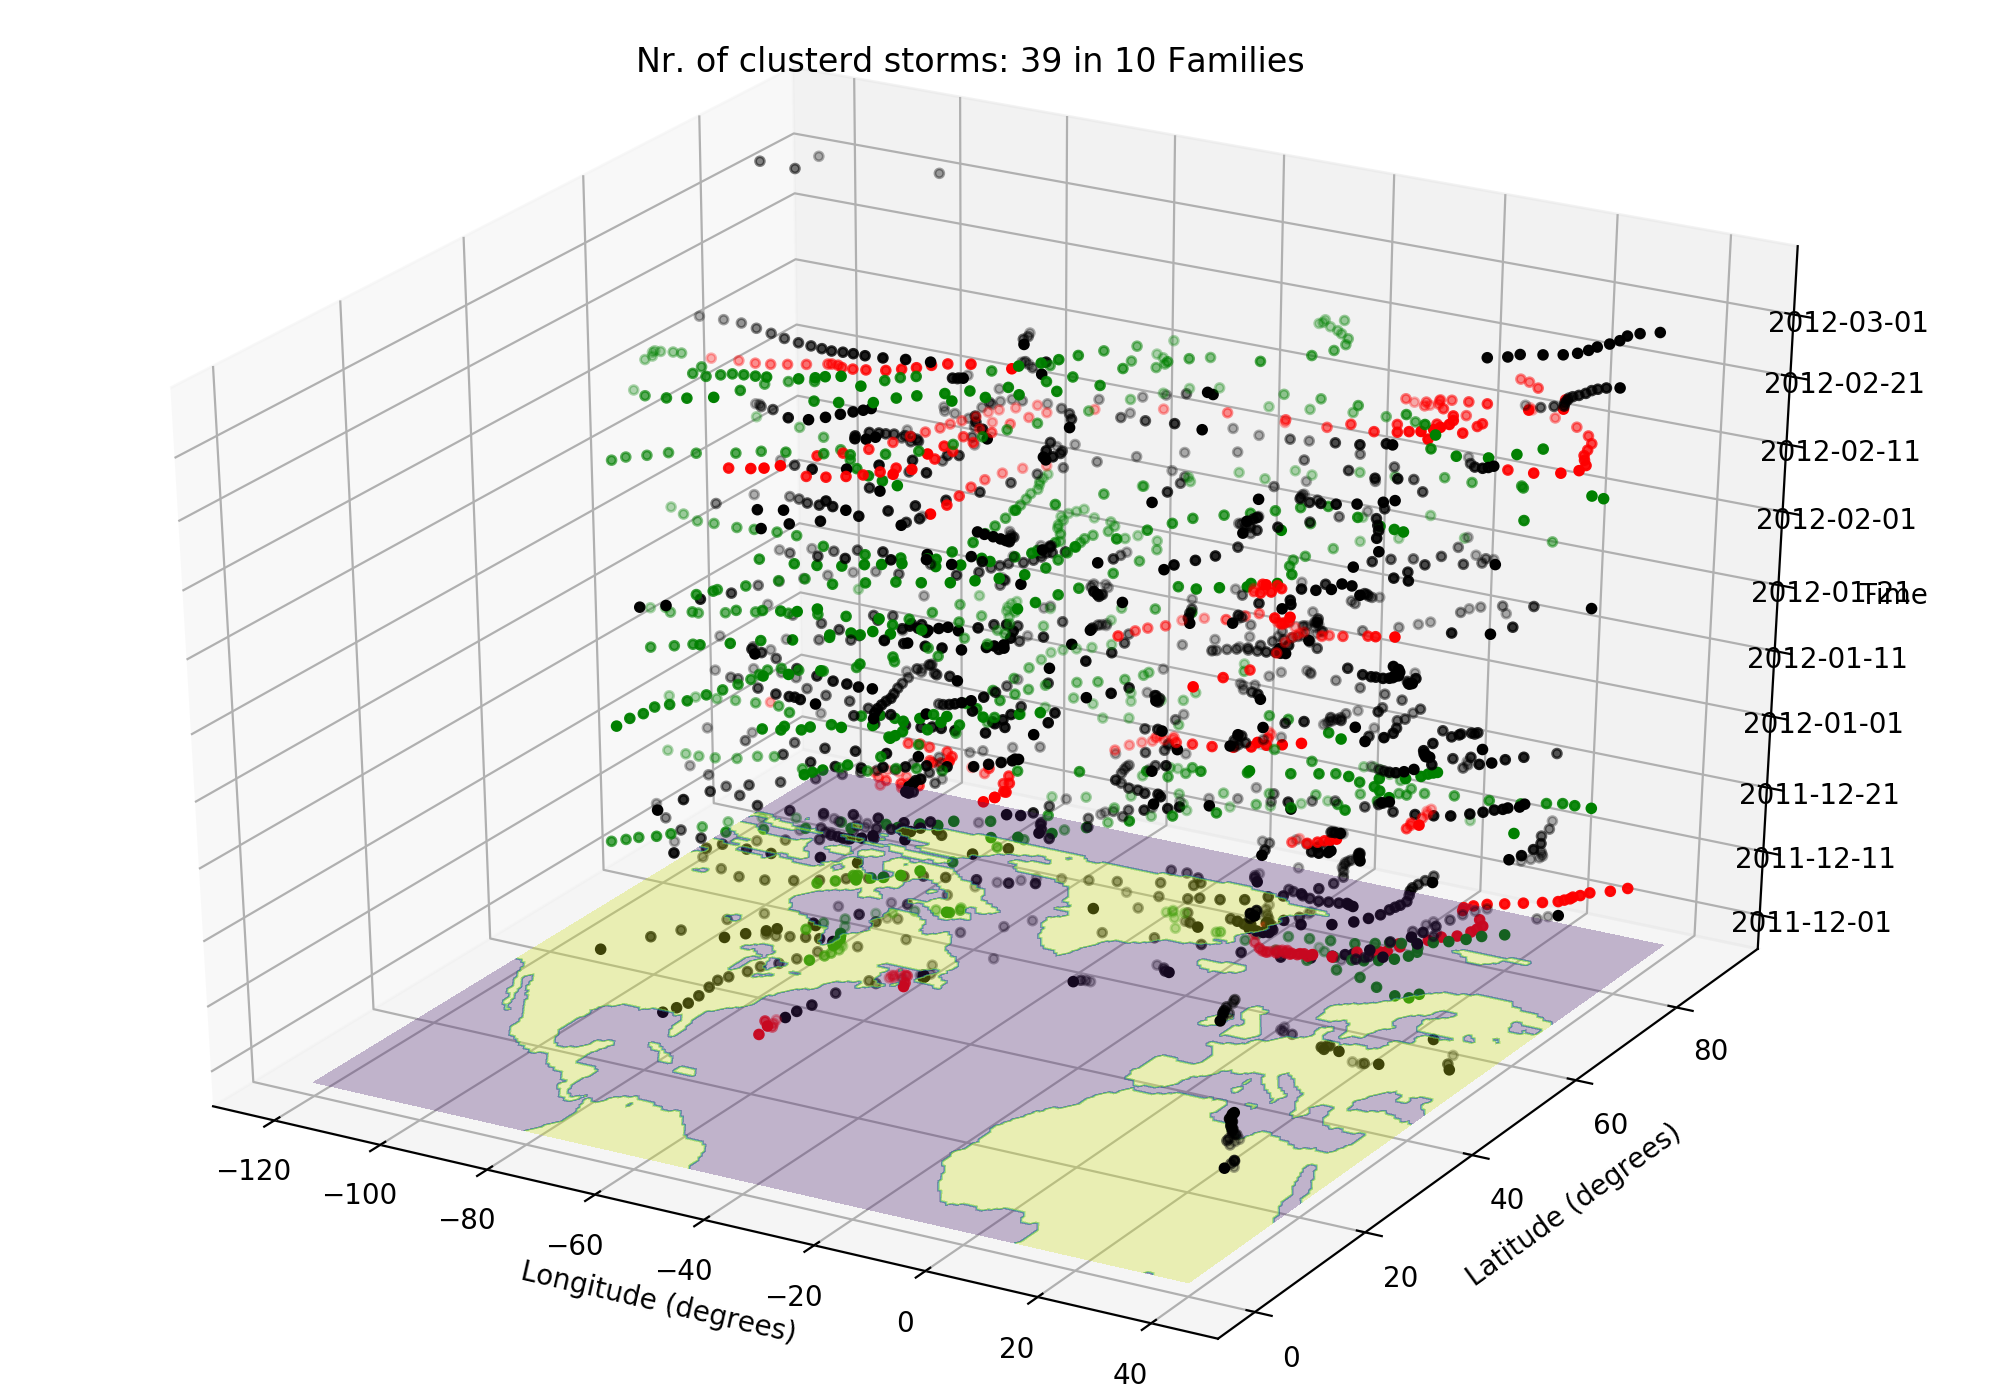

In [106]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection="3d")

for strid in selstrid:
        tmp_dt = str_dt[str_id == uniq_ids[strid]]
        tmp_datefloat = dates.date2num(tmp_dt) #-firstdt # converted
        tmp_lon = str_lon[str_id == uniq_ids[strid]]
        tmp_lon[tmp_lon > 180] = tmp_lon[tmp_lon > 180] - 360.0
        tmp_lat = str_lat[str_id == uniq_ids[strid]]
        #print("Storm " + str(strid))
        #print(tmp_lon)
        #print(tmp_lat)

        #Delete points outside data range
        if(np.any(tmp_lon > 40) ):
                delidxs = np.where(tmp_lon > 40)
                tmp_lon = np.delete(tmp_lon,delidxs)
                tmp_lat = np.delete(tmp_lat,delidxs)
                tmp_datefloat = np.delete(tmp_datefloat,delidxs)
                tmp_dt = np.delete(tmp_dt,delidxs)

        if(np.any(tmp_lon < - 120) ):
                delidxs = np.where(tmp_lon < -120)
                tmp_lon = np.delete(tmp_lon,delidxs)
                tmp_lat = np.delete(tmp_lat,delidxs)
                tmp_datefloat = np.delete(tmp_datefloat,delidxs)
                tmp_dt = np.delete(tmp_dt,delidxs)

        if( uniq_ids[strid] in plotstrms):            
                col = "gray"
                atl_nonclust += 1
        else:
                colidx = np.where([uniq_ids[strid] in x for x in plotclusters])[0]
                colidx = colidx%len(colclust)

                col = colclust[colidx[0]]
                atl_clust += 1

        #ax.plot3D(tmp_lon, tmp_lat, tmp_datefloat, col,linewidth=2)
        if(angleTypes[strid] == "Length"):
            ax.scatter3D(tmp_lon, tmp_lat, tmp_datefloat, c="Blue",s=10);
        elif(angleTypes[strid] == "Time"):
            ax.scatter3D(tmp_lon, tmp_lat, tmp_datefloat, c='Red',s=10);
        elif(angleTypes[strid] == "Mixed"):
            ax.scatter3D(tmp_lon, tmp_lat, tmp_datefloat, c='Green',s=10);
        else:
            ax.scatter3D(tmp_lon, tmp_lat, tmp_datefloat, c='Black',s=10);
            
#3D mask at bottom of land-sea
lon = ds.coords['longitude'].values 
lat = ds.coords['latitude'].values
lon2d = np.tile(lon,(len(lat),1))
lat2d = np.tile(lat,(len(lon),1)).transpose()
#, time = ds.indexes.values()

cset = ax.contourf(lon2d,lat2d,
                   ds['lsm'].data.squeeze(),offset=firstdt,
                  alpha=0.3) #lon_mask, lat_mask, val_mask

#Change z-axis formatting to dates
ax.zaxis.set_major_locator(dates.DayLocator([1,11,21]))
ax.zaxis.set_major_formatter(ticker.FuncFormatter(format_date))
#ax.set_zlim(firstdt,734570.75)
ax.set_zlim(firstdt,lastdt)

plt.subplots_adjust(left=-0.03,right=1.0,bottom=-0.02,top=1.02)
plt.xlabel("Longitude (degrees)")
plt.ylabel("Latitude (degrees)")
ax.set_zlabel("Time")
plt.title("Nr. of clusterd storms: " + str(len(plotclststrms)) + " in " + str(len(plotclusters)) + " Families")

plt.show()

<IPython.core.display.Javascript object>


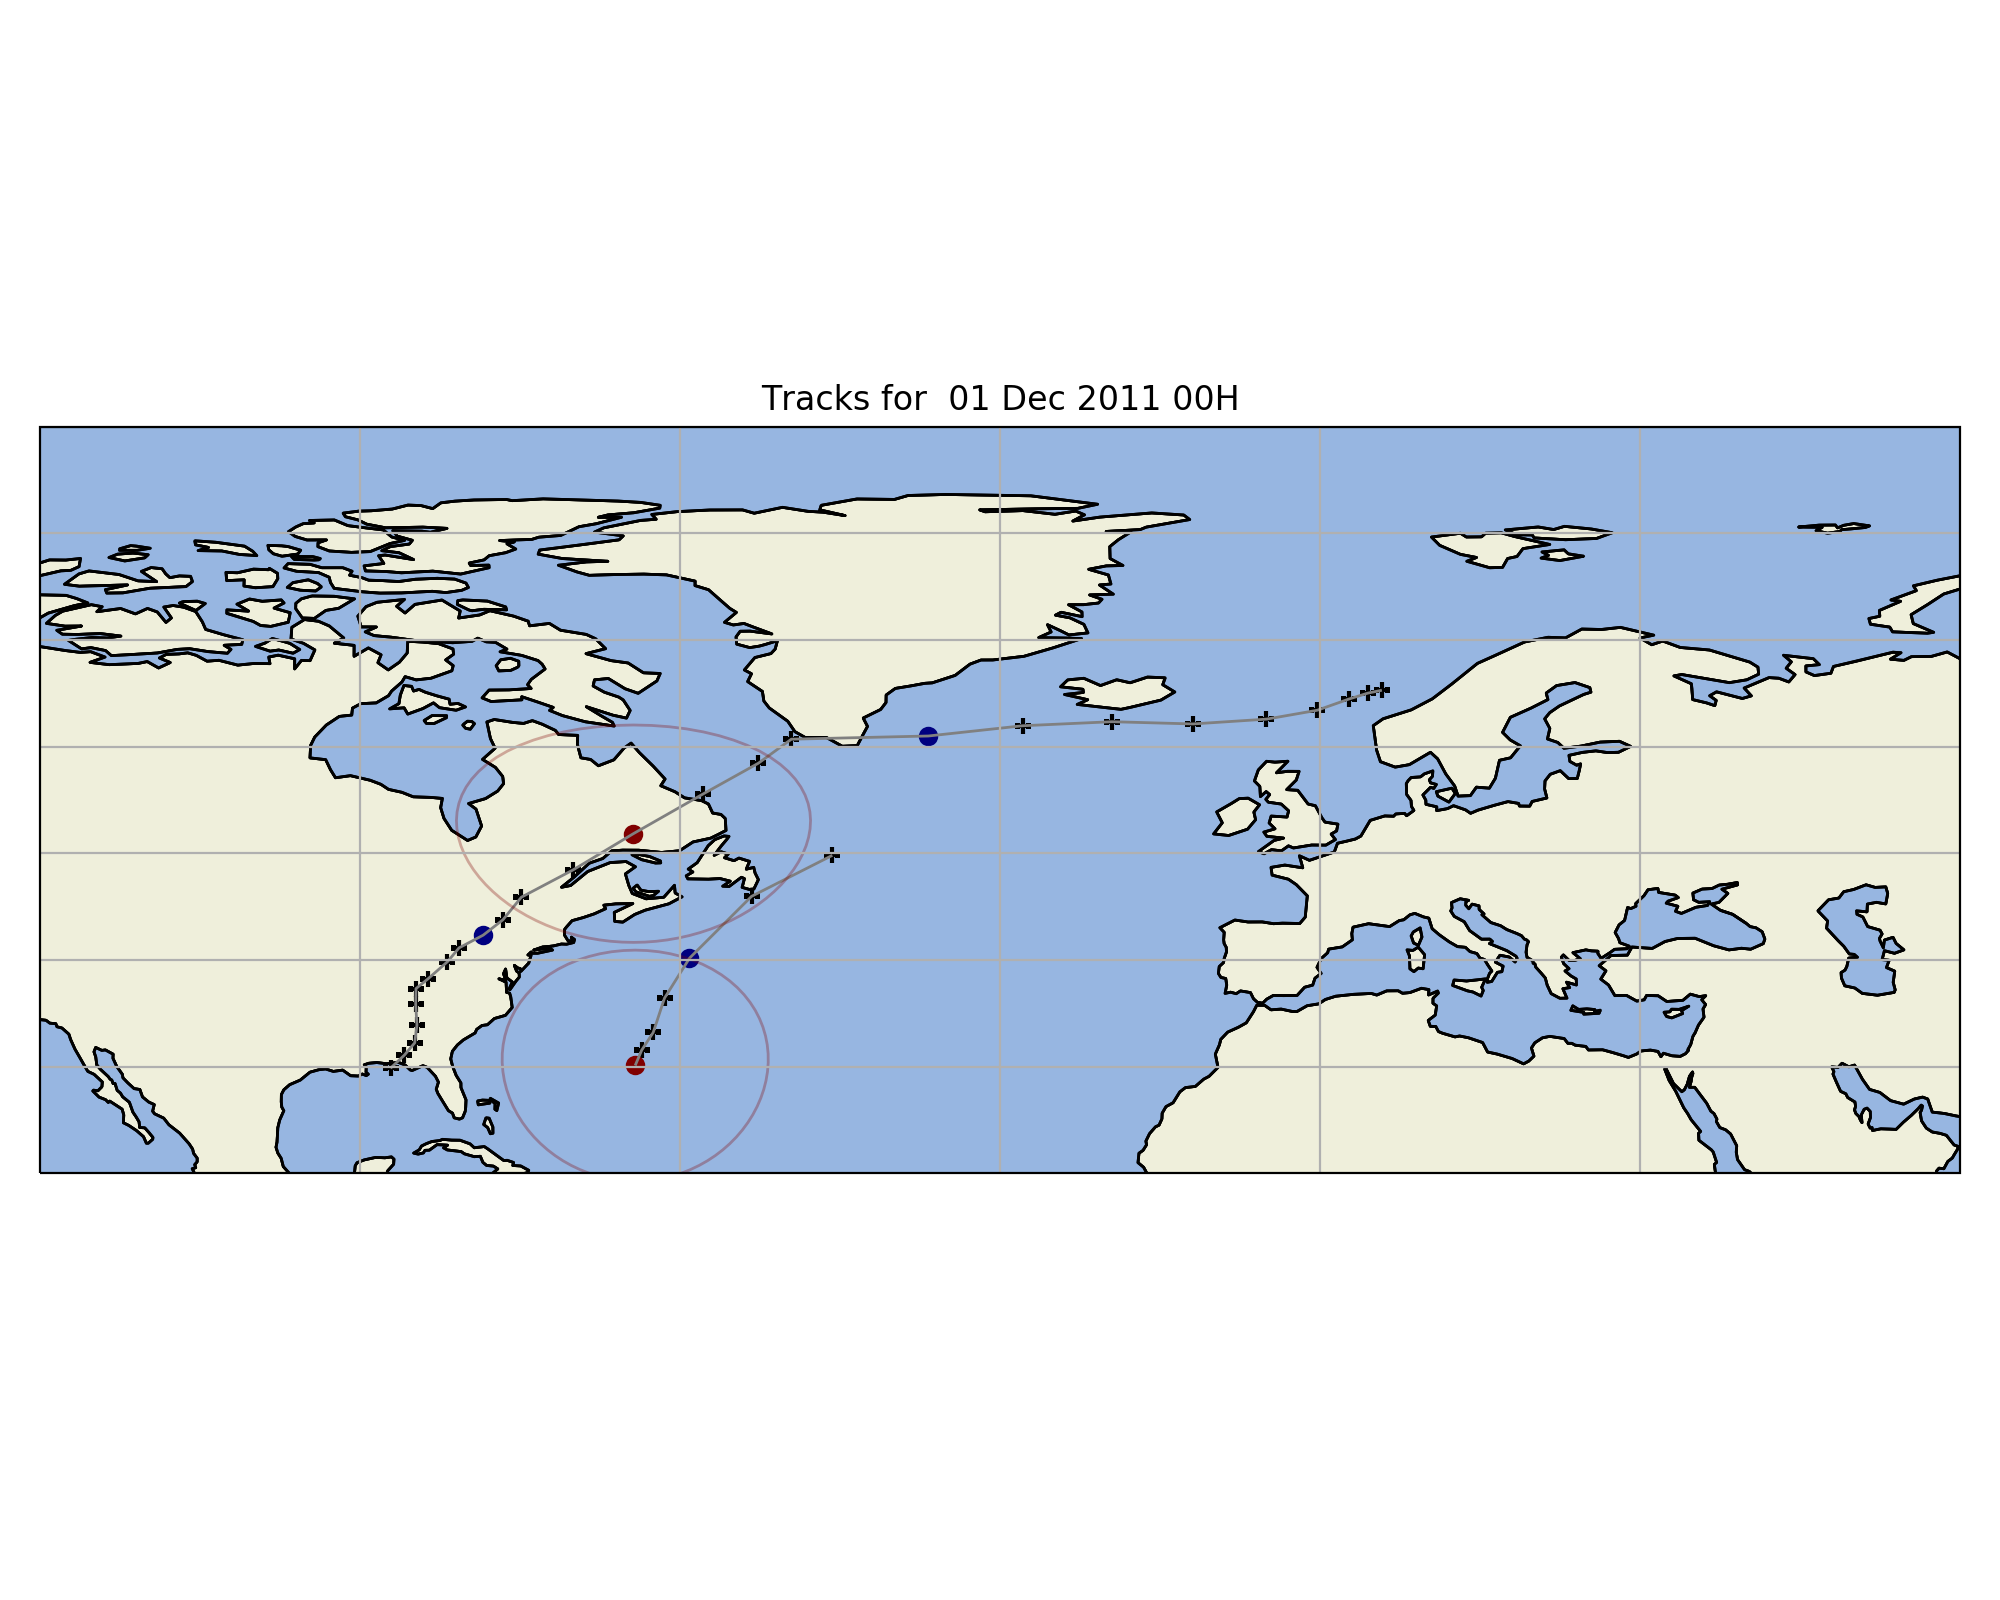

interactive(children=(SelectionSlider(description='Date', index=13, layout=Layout(width='800px'), options=(dat…

<function __main__.update(seldate=datetime.datetime(2011, 12, 1, 0, 0))>

In [162]:
import cartopy
import cartopy.crs as ccrs


seldates = np.unique(str_dt)

options = [(date.strftime(' %d %b %Y %HH'), date) for date in seldates]

date_slider = SelectionSlider(
    options=seldates,
    index=13 ,
    description='Date',
    orientation='horizontal',
    layout={'width': '800px'}
)
#date_range_slider


plt.figure(figsize=(10,8))
#projFig = ccrs.Orthographic(-10, 45)
projFig = ccrs.PlateCarree()
#projFig = ccrs.NearsidePerspective(central_longitude=-45.0, central_latitude=50.0, satellite_height=6785831, false_easting=0, false_northing=0, globe=None)
#satellite_height=35785831
ax = plt.axes(projection=projFig)
#ax.set_extent([-120, 60, 20, 90])

ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
ax.add_feature(cartopy.feature.OCEAN, zorder=0, edgecolor='black')
ax.coastlines(resolution='110m')

#ax.set_global()
#ax.gridlines()

#ax.quiver(x, y, u, v, transform=vector_crs)
colclust = ["red","dodgerblue","Darkgreen","Orange","Purple","Brown","Yellow","lightblue"]
colclust = ["#e6194B", "#3cb44b", "#ffe119", "#4363d8", "#f58231", "#911eb4", "#42d4f4", "#f032e6", "#bfef45", "#fabebe", "#469990", "#e6beff", "#9A6324", "#fffac8", "#800000", "#aaffc3", "#808000", "#ffd8b1", "#000075", "#000000"] #, #a9a9a9, #ffffff, 

def update(seldate = dt(2011,12,1,0,0)):
    
    #print(seldate)
    #type(seldate)
    plt.clf()
    ax = plt.axes(projection=projFig)
    ax.set_extent([-120, 60, 20, 90])

    ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
    ax.add_feature(cartopy.feature.OCEAN, zorder=0, edgecolor='black')
    ax.coastlines(resolution='110m')

    ax.gridlines()

    selstrid = str_id[str_dt == seldate]
    sel_lons = []
    sel_lats = []

    sel_lons2 = []
    sel_lats2 = []
    
    for strid in selstrid:
        
        if(strid in plotstrms):            
            col = "gray"
        else:
            colidx = np.where([strid in x for x in plotclusters])[0]
            colidx = colidx%len(colclust)

            col = colclust[colidx[0]]

        tmp_dt = str_dt[str_id == strid]
        tmp_datefloat = dates.date2num(tmp_dt) #-firstdt # converted
        tmp_lon = str_lon[str_id == strid]
        tmp_lon[tmp_lon > 180] = tmp_lon[tmp_lon > 180] - 360.0
        tmp_lat = str_lat[str_id == strid]

        #Delete points outside data range
        if(np.any(tmp_lon > 40) ):
                delidxs = np.where(tmp_lon > 40)
                tmp_lon = np.delete(tmp_lon,delidxs)
                tmp_lat = np.delete(tmp_lat,delidxs)
                tmp_datefloat = np.delete(tmp_datefloat,delidxs)
                tmp_dt = np.delete(tmp_dt,delidxs)

        if(np.any(tmp_lon < - 120) ):
                delidxs = np.where(tmp_lon < -120)
                tmp_lon = np.delete(tmp_lon,delidxs)
                tmp_lat = np.delete(tmp_lat,delidxs)
                tmp_datefloat = np.delete(tmp_datefloat,delidxs)
                tmp_dt = np.delete(tmp_dt,delidxs)
                
                
        #Select only the tracks of this specific time step: 
        for lidx in range(len(tmp_lon)):
                if((tmp_lon[lidx] <= 0) & (tmp_lon[lidx] >= -10)):
                        break

        # turn the lons and lats into a shapely LineString
        if(len(tmp_lon) > 1):
            track = sgeom.LineString(zip(list(tmp_lon), list(tmp_lat)))
        
            if( strid in plotstrms):            
                col = "gray"
            else:
                colidx = np.where([strid in x for x in plotclusters])[0]
                colidx = colidx%len(colclust)

                col = colclust[colidx[0]]

            #ax.lines(tmp_lon, tmp_lat, tmp_datefloat, col,linewidth=1)
            track_plot = ax.add_geometries([track], projFig, edgecolor=col,facecolor='none') #'firebrick'
            
            #Add points to indicate the respective points of current time steps
            sel_lons.extend(tmp_lon[tmp_dt == seldate]) 
            sel_lats.extend(tmp_lat[tmp_dt == seldate]) 

            # Add markers where the storm was 1 day before and after
            sel_lons2.extend(tmp_lon[tmp_dt == seldate - td(days=1)]) 
            sel_lats2.extend(tmp_lat[tmp_dt == seldate - td(days=1)]) 
            
            # Add markers where the storm was 1 day before and after
            sel_lons2.extend(tmp_lon[tmp_dt == seldate + td(days=1)]) 
            sel_lats2.extend(tmp_lat[tmp_dt == seldate + td(days=1)]) 
            
            #Different times
            plt.scatter(tmp_lon, tmp_lat, color='black', marker='+')
            
    plt.scatter(sel_lons, sel_lats, color='maroon', 
         marker='o')
    plt.scatter(sel_lons2,sel_lats2, color='navy',  
         marker='o')
    
    for idx in range(len(sel_lons)):
        ax.tissot(rad_km=min(distthresh*calc_Rossby_radius(lat=sel_lats[idx]),1200), lons=sel_lons[idx], lats=sel_lats[idx], alpha=0.3,edgecolor='maroon',facecolor='none')
    #ax.tissot(rad_km=500, lons=[-70], lats=[75], alpha=0.3)
    
    plt.title("Tracks for " + seldate.strftime(' %d %b %Y %HH'))

    fig.canvas.draw_idle()
    

#'''
plt.subplots_adjust(left=0.02,right=0.98,bottom=-0.25,top=1.25)
plt.show()
        
#interact(update);
interact(update,seldate=date_slider)


In [61]:
lastdt = dates.date2num(str_dt[-1])
lastdt

734570.75

In [62]:
atl_clust

53

In [63]:
np.nanquantile(anglesClust,0.95)

77.99898129218084

<IPython.core.display.Javascript object>


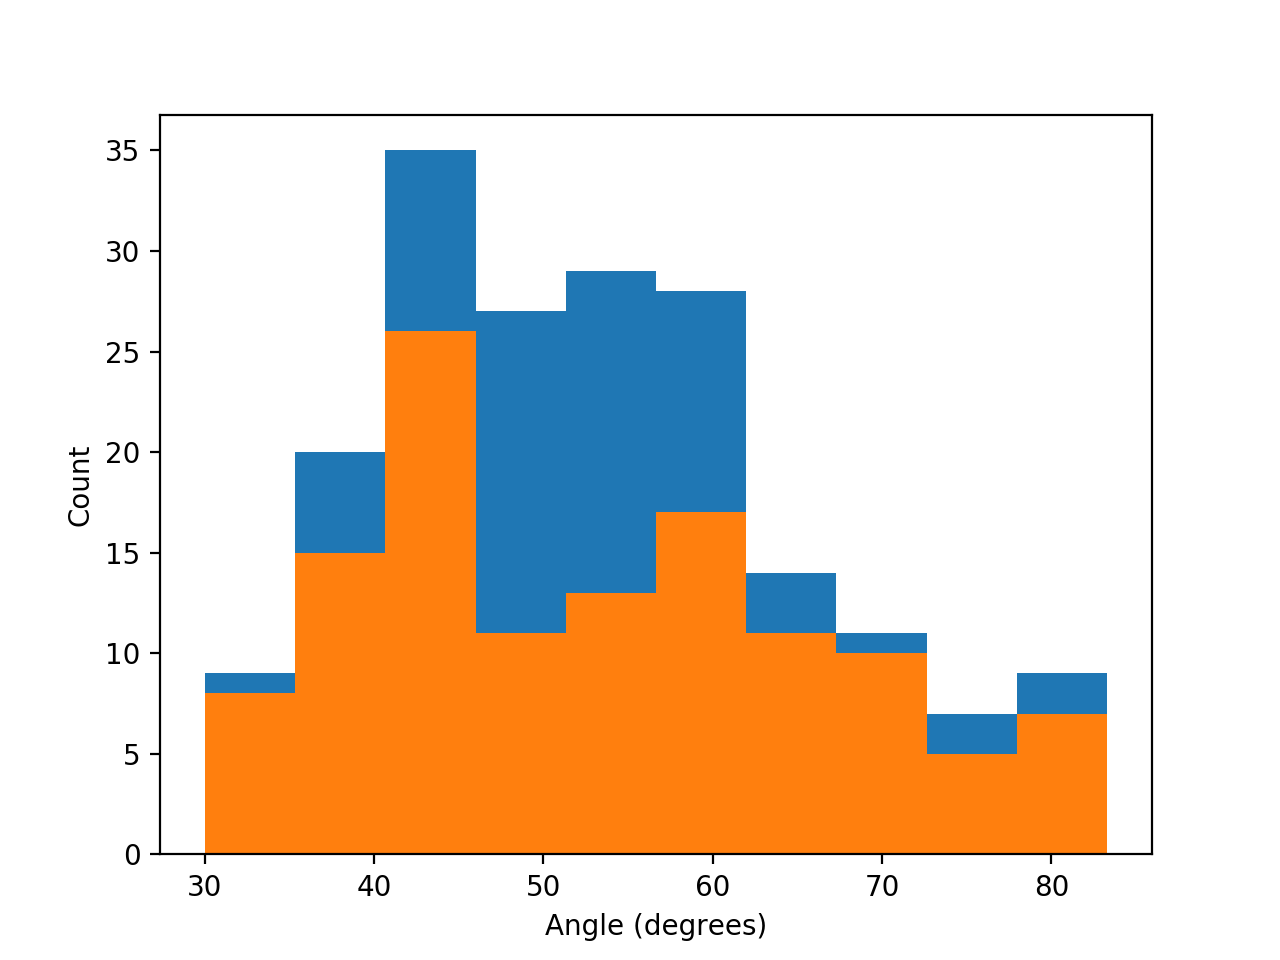

Text(0.5,0,'Angle (degrees)')

In [64]:
plt.figure()
plt.hist(angles)
plt.hist(anglesClust)
plt.ylabel("Count")
plt.xlabel("Angle (degrees)")

In [41]:
atl_clust

58

In [182]:
atl_nonclust


113

## Types of Clusters

<IPython.core.display.Javascript object>


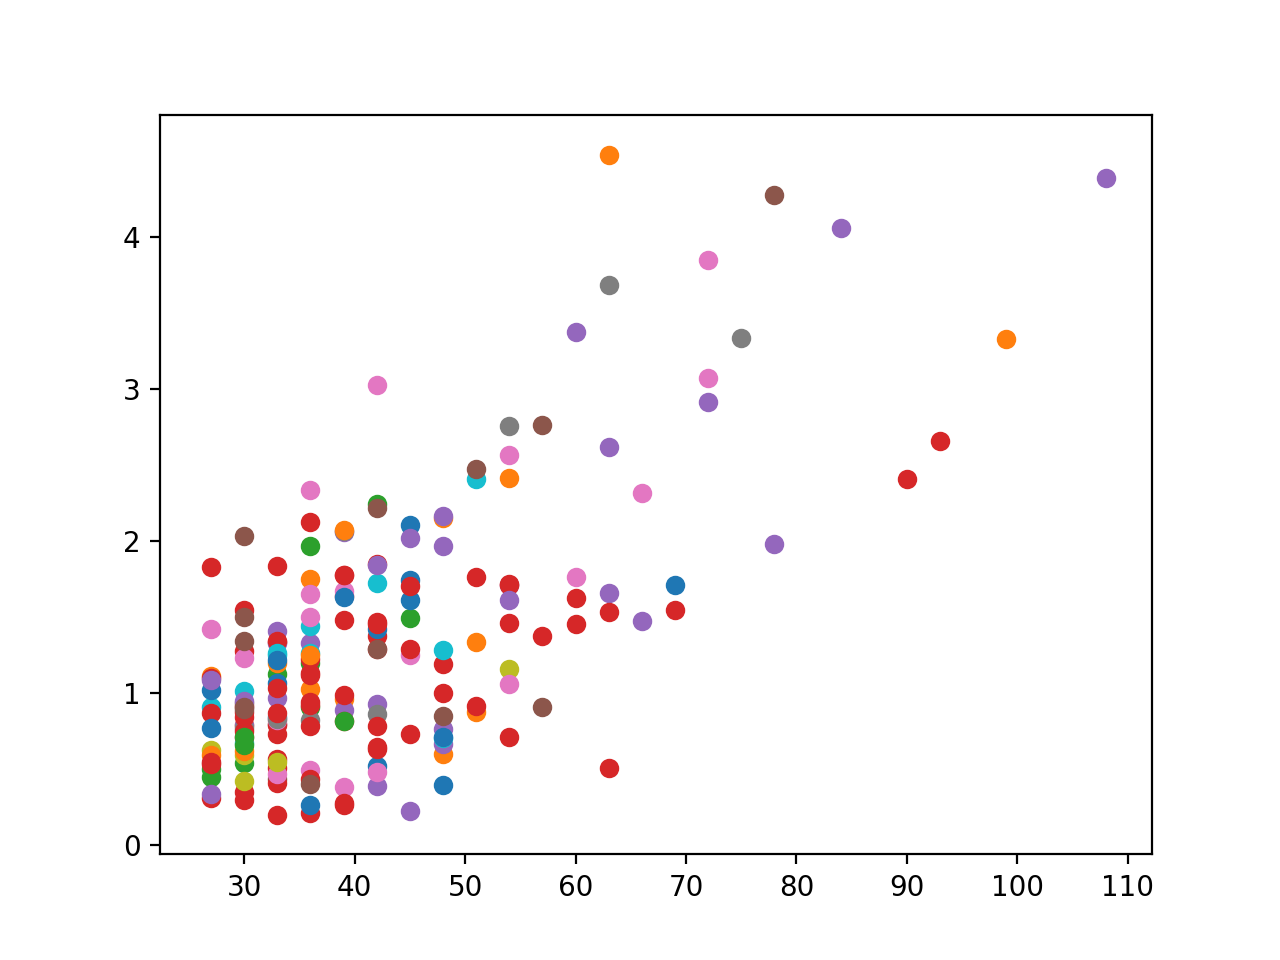

[78.825209981862, 67.72786962457324]
73.27653980321762 5.548670178644379
[78.6528341551344, 67.21342790464111, 68.42862797170606]
71.43163001049386 5.130205959132569
[62.03251794711346, 61.96334642815931, 49.508212831025844, 68.01729504428491, 61.38138449888663]
60.58055134989404 6.042573955077682
[62.31344930643164, 57.02421606113993, 56.05663498557045, 71.52953375857543, 61.432655828451836]
61.67129798803386 5.491337395755808
[63.1189680917008, 70.03665420233315, 70.53093347358976, 64.91782148032632, 70.33319272716676, 56.35344712245946, 49.82466811065153, 57.06969384771439, 67.24093142540767, 77.52432960547195, 75.74846287690406, 81.60573577804666, 59.424140883183924, 55.73506447573188, 56.96619327969297, 57.2354368332846, 52.27351556343664, 85.509605957277, 67.13431793236445]
65.18858492982862 9.833609397290642
[78.10436215078984, 75.67801358867919, 68.88687649657697]
74.223084078682 3.901121663974819
[79.61010417310895, 81.1613321685411, 49.44869532351147, 43.94420149828844, 55.66

In [183]:
plt.figure()


for cluster in sorted_clusters:
    if(len(cluster) > 2):
        sort_storms = np.sort(cluster)
        #print(cluster)
        test = [ list(angleTracks[strm-1,:][angleTracks[strm-1,:] != 0]) for strm in cluster]
        tmp_angles = [angle for strm in cluster for angle in list(angleTracks[strm-1,:][angleTracks[strm-1,:] != 0])]
        tmp_dr = [dr for strm in cluster for dr in list(drTracks[strm-1,:][drTracks[strm-1,:] != 0])]
        tmp_dt = [dt for strm in cluster for dt in list(dtTracks[strm-1,:][dtTracks[strm-1,:] != 0])]
        
        plt.scatter(np.array(tmp_dt)*timlngthresh*6.0,np.array(tmp_dr)*lngthresh)
        #test2 = [angle for angle in list(angleTracks[strm-1,:]) for strm in cluster if angle != 0]
        print(tmp_angles)
        print(np.nanmean(tmp_angles),np.nanstd(tmp_angles))
        
            

In [8]:
anglesClust

[]

In [185]:
nrPairs = np.nansum((np.abs(timdiffs) <= timthresh) & (dists <= distthresh))

<IPython.core.display.Javascript object>


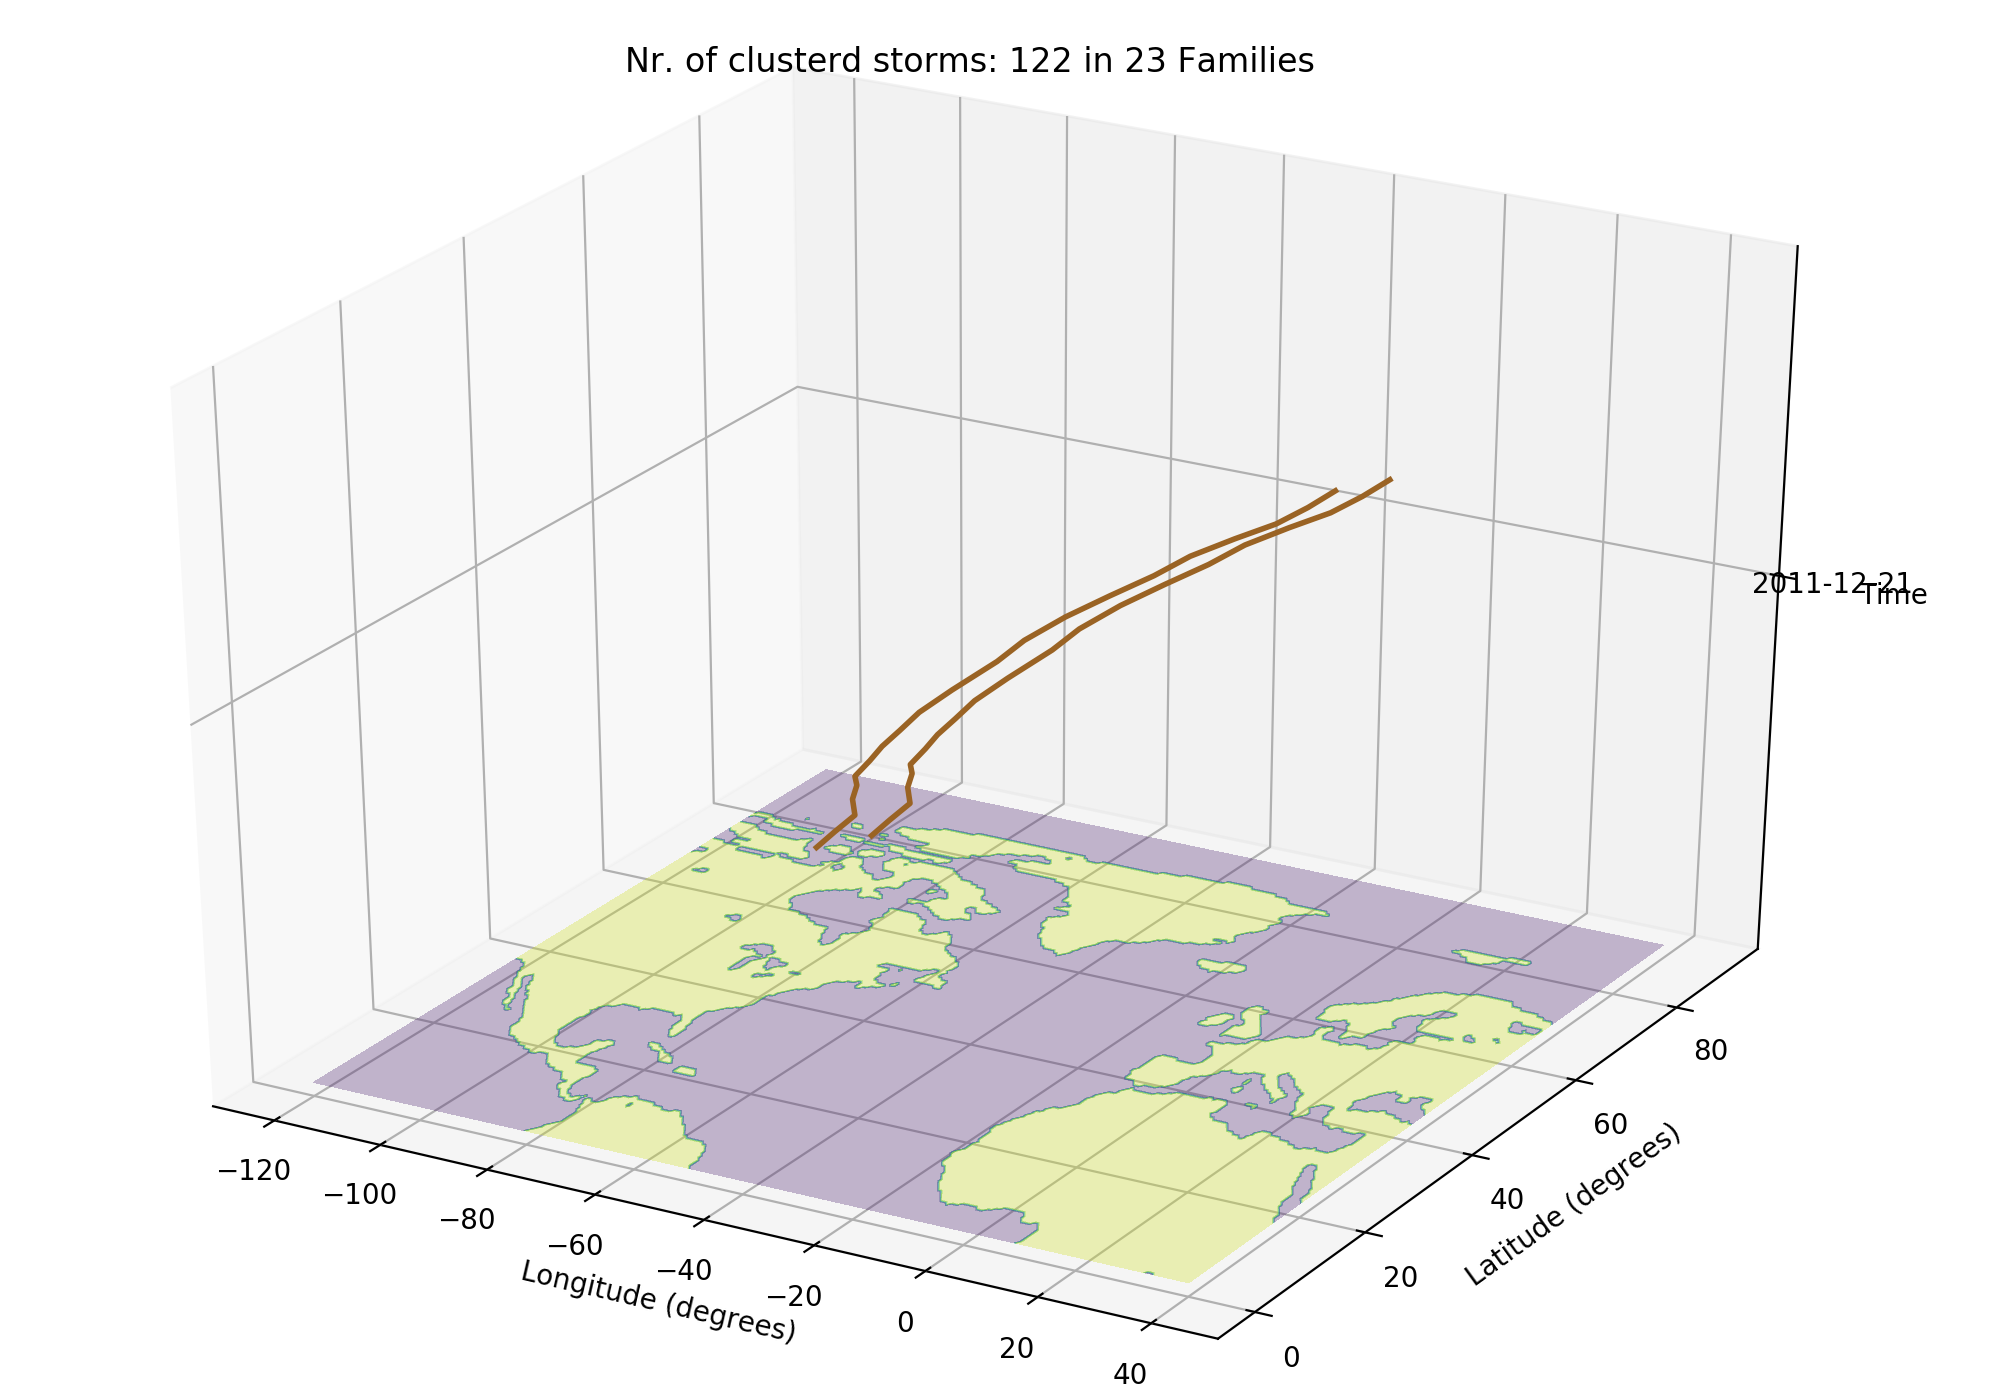

In [94]:
################################
# Plot Tracks of 2011/12 winter
################################
# matplotlib date format object
%matplotlib notebook
hfmt = dates.DateFormatter('%m/%d %H:%M')

def format_date(x, pos=None):
    return dates.num2date(x).strftime('%Y-%m-%d') #use FuncFormatter to format dates

#Min/Max longitude and latitude used in plots
lon_min = -120
lon_max = 40
lat_min = 0
lat_max = 90
        
# Load landmask data
ds = xr.open_dataset("ei.ans.land-sea.nc")
ds = ds.sel(longitude=slice(lon_min,lon_max),latitude=slice(lat_max,lat_min))

fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection="3d")

tmp_dt = str_dt[str_id == uniq_ids[0]]
firstdt = dates.date2num(tmp_dt)[0] # converted
lastdt = dates.date2num(str_dt[-1])
firstdt = dates.date2num(dt(2011,12,15))
lastdt = dates.date2num(dt(2011,12,26))

eastatl_lats = []
eastatl_tims = []

colclust = ["red","dodgerblue","Darkgreen","Orange","Purple","Brown","Yellow","lightblue"]
colclust = ["#e6194B", "#3cb44b", "#ffe119", "#4363d8", "#f58231", "#911eb4", "#42d4f4", "#f032e6", "#bfef45", "#fabebe", "#469990", "#e6beff", "#9A6324", "#fffac8", "#800000", "#aaffc3", "#808000", "#ffd8b1", "#000075", "#000000"] #, #a9a9a9, #ffffff, 


atl_clust = 0
atl_nonclust = 0

for strid in selstrid[35:36]:
        tmp_dt = str_dt[str_id == uniq_ids[strid]]
        tmp_datefloat = dates.date2num(tmp_dt) #-firstdt # converted
        tmp_lon = str_lon[str_id == uniq_ids[strid]]
        tmp_lon[tmp_lon > 180] = tmp_lon[tmp_lon > 180] - 360.0
        tmp_lat = str_lat[str_id == uniq_ids[strid]]
        #print("Storm " + str(strid))
        #print(tmp_lon)
        #print(tmp_lat)

        #Delete points outside data range
        if(np.any(tmp_lon > 40) ):
                delidxs = np.where(tmp_lon > 40)
                tmp_lon = np.delete(tmp_lon,delidxs)
                tmp_lat = np.delete(tmp_lat,delidxs)
                tmp_datefloat = np.delete(tmp_datefloat,delidxs)
                tmp_dt = np.delete(tmp_dt,delidxs)

        if(np.any(tmp_lon < - 120) ):
                delidxs = np.where(tmp_lon < -120)
                tmp_lon = np.delete(tmp_lon,delidxs)
                tmp_lat = np.delete(tmp_lat,delidxs)
                tmp_datefloat = np.delete(tmp_datefloat,delidxs)
                tmp_dt = np.delete(tmp_dt,delidxs)

        for lidx in range(len(tmp_lon)):
                if((tmp_lon[lidx] <= 0) & (tmp_lon[lidx] >= -10)):
                        eastatl_lats.append(tmp_lat[lidx])
                        eastatl_tims.append(tmp_datefloat[lidx])
                        break

        if( uniq_ids[strid] in plotstrms):            
                col = "gray"
                atl_nonclust += 1
        else:
                colidx = np.where([uniq_ids[strid] in x for x in plotclusters])[0]
                colidx = colidx%len(colclust)

                col = colclust[colidx[0]]
                atl_clust += 1

        ax.plot3D(tmp_lon, tmp_lat, tmp_datefloat, col,linewidth=2)
        ax.plot3D(tmp_lon + 5, tmp_lat + 5, tmp_datefloat, col,linewidth=2)

lon = ds.coords['longitude'].values 
lat = ds.coords['latitude'].values
lon2d = np.tile(lon,(len(lat),1))
lat2d = np.tile(lat,(len(lon),1)).transpose()
#, time = ds.indexes.values()

cset = ax.contourf(lon2d,lat2d,
                   ds['lsm'].data.squeeze(),offset=firstdt,
                  alpha=0.3) #lon_mask, lat_mask, val_mask

#Change z-axis formatting to dates
ax.zaxis.set_major_locator(dates.DayLocator([1,11,21]))
ax.zaxis.set_major_formatter(ticker.FuncFormatter(format_date))
#ax.set_zlim(firstdt,734570.75)
ax.set_zlim(firstdt,lastdt)

#ax.set_zlim(firstdt,dates.date2num(dt(2011,12,11,0)))

plt.subplots_adjust(left=-0.03,right=1.0,bottom=-0.02,top=1.02)
plt.xlabel("Longitude (degrees)")
plt.ylabel("Latitude (degrees)")
ax.set_zlabel("Time")
plt.title("Nr. of clusterd storms: " + str(len(plotclststrms)) + " in " + str(len(plotclusters)) + " Families")

plt.show()

In [194]:
np.nansum(connTracks == 2.0)

306

In [233]:
#Recursive function to find uniquely connected cluster of storms + Type of cluster
def find_cluster_type(cluster,connTracks):
    #print("CLustering analysis for the following storms:")
    #print(cluster)
    cluster_old = cluster

    #Loop over storms to find connected storms
    for stridx in cluster: 
        conntemp = connTracks[stridx,::] #-1
        if(np.nansum(conntemp) > 0):
            strmstemp = np.where(conntemp > 0)[0]  #+ stridx
            #typetemp = conntemp[conntemp > 0] 
            cluster = np.append(cluster,np.array(strmstemp,dtype=int))

    #Remove duplicate storms
    cluster = np.unique(cluster)

    #Check if all storms are counted??
    if(len(cluster) == len(cluster_old)):
        connTypes = [x for strm in cluster for x in list(connTracks[strm,:][connTracks[strm,:] != 0])]
        
        if(len(cluster) == 1):
            clusterType = "None"
        elif(all((x == 2.0 or x == 3.0) for x in connTypes)):
            clusterType = "Length"
        elif(all((x == 1.0 or x == 3.0) for x in connTypes)):
            clusterType = "Time"
        else:
            clusterType = "Mixed"
        
        return cluster_old, connTypes, clusterType
    else:
        #connTypes.extend(list(typetemp))
        return find_cluster_type(cluster,connTracks)

cluster_old, connTypes, clusterType = find_cluster_type([99], connTracks)

clusterType

'Time'

In [238]:
cluster_old, connTypes, clusterType = find_cluster_type([99], connTracks)

In [262]:
np.nansum(np.array(clusterTypes) == "Mixed")

33

In [9]:
print(connTypes)
all((x == 1.0 or x == 3.0) for x in connTypes)

[]


True

In [65]:
np.nanmean(anglesClust)

53.17435846499656

In [24]:
len(anglesClust)

7994

In [8]:
angleTypes

['Time',
 'None',
 'None',
 'None',
 'None',
 'None',
 'Time',
 'None',
 'Length',
 'None',
 'None',
 'None',
 'None',
 'None',
 'Length',
 'None',
 'None',
 'None',
 'None',
 'None',
 'Time',
 'None',
 'None',
 'None',
 'Length',
 'None',
 'None',
 'Time',
 'Length',
 'Time',
 'None',
 'None',
 'Time',
 'Time',
 'None',
 'Time',
 'None',
 'None',
 'None',
 'Time',
 'Length',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'Time',
 'Time',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'Time',
 'Time',
 'Length',
 'None',
 'Time',
 'None',
 'None',
 'Time',
 'None',
 'None',
 'Length',
 'Time',
 'None',
 'None',
 'None',
 'None',
 'None',
 'Length',
 'None',
 'Time',
 'Length',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'Length',
 'Length',
 'Length',
 'None',
 'Length',
 'Time',
 'Time',
 'None',
 'Length',
 'None',
 'Time',
 'Length',
 'None',
 'Time',
 'Time',
 'None',
 'None'

In [12]:
angleTypes

['Time',
 'None',
 'None',
 'None',
 'None',
 'None',
 'Time',
 'None',
 'Length',
 'None',
 'None',
 'None',
 'None',
 'None',
 'Length',
 'None',
 'None',
 'None',
 'None',
 'None',
 'Time',
 'None',
 'None',
 'None',
 'Length',
 'None',
 'None',
 'Time',
 'Length',
 'Mixed',
 'None',
 'None',
 'Mixed',
 'Time',
 'None',
 'Mixed',
 'None',
 'None',
 'None',
 'Mixed',
 'Length',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'Time',
 'Mixed',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'Mixed',
 'Time',
 'Mixed',
 'None',
 'Time',
 'None',
 'None',
 'Time',
 'None',
 'None',
 'Mixed',
 'Mixed',
 'None',
 'None',
 'None',
 'None',
 'None',
 'Mixed',
 'None',
 'Time',
 'Mixed',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'Mixed',
 'Mixed',
 'Mixed',
 'None',
 'Mixed',
 'Mixed',
 'Time',
 'None',
 'Mixed',
 'None',
 'Time',
 'Mixed',
 'None',
 'Time',
 'Mixed',
 'None',
 'None',

In [36]:
len(angleTypes)

432

In [79]:
#Recursive function to find uniquely connected cluster of storms + Type of cluster
def find_cluster_type(cluster,connTracks,contype="All"):
    #print("CLustering analysis for the following storms:")
    #print(cluster)
    cluster_old = cluster

    #Loop over storms to find connected storms
    for stridx in cluster: 
        conntemp = connTracks[stridx,::] #-1
        if(contype == "All" and np.nansum(conntemp) > 0):
            strmstemp = np.where(conntemp > 0)[0]  #+ stridx
            #typetemp = conntemp[conntemp > 0] 
            cluster = np.append(cluster,np.array(strmstemp,dtype=int))
        elif(contype == "Length" and np.nansum((conntemp == 1.0) | (conntemp == 3.0)) > 0):
            strmstemp = np.where((conntemp == 1.0) | (conntemp == 3.0))[0]  #+ stridx
            #typetemp = conntemp[conntemp > 0] 
            cluster = np.append(cluster,np.array(strmstemp,dtype=int))
        elif(contype == "Time" and np.nansum(conntemp >= 2.0) > 0):
            strmstemp = np.where(conntemp >= 2.0)[0]  #+ stridx
            #typetemp = conntemp[conntemp > 0] 
            cluster = np.append(cluster,np.array(strmstemp,dtype=int))    
            
            
    #Remove duplicate storms
    cluster = np.unique(cluster)

    #Check if all storms are counted??
    if(len(cluster) == len(cluster_old)):
        if(contype == "All"):
            connTypes = [x for strm in cluster for x in list(connTracks[strm,:][connTracks[strm,:] != 0])]
        elif(contype == "Length"):
            connTypes = [x for strm in cluster for x in list(connTracks[strm,:][(connTracks[strm,:] == 1.0) | (connTracks[strm,:] == 3.0)])]
        elif(contype == "Time"):
            connTypes = [x for strm in cluster for x in list(connTracks[strm,:][connTracks[strm,:] >= 2.0])]
        else:
            connTypes = []
            
        if(len(cluster) == 1):
            clusterType = "None"
        elif(all((x == 2.0 or x == 3.0) for x in connTypes)):
            clusterType = "Time"
        elif(all((x == 1.0 or x == 3.0) for x in connTypes)):
            clusterType = "Length"
        else:
            clusterType = "Mixed"
        
        return cluster_old, connTypes, clusterType
    else:
        #connTypes.extend(list(typetemp))
        return find_cluster_type(cluster,connTracks,contype=contype)

In [85]:
find_cluster_type([99],connTracks,contype="Time")

(array([ 66,  74,  81,  99, 108, 109, 117, 127]),
 [2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 3.0, 2.0],
 'Time')

In [45]:
find_cluster([99],connTracks)

array([ 66,  74,  81,  93,  99, 108, 109, 117, 127])

In [88]:
def unnest(l,level=1):
    
    l_unnest = [item for sublist in l for item in sublist]
    #print(l_unnest)
    #print(level)
    if(level > 1):
        l_unnest = unnest(l=l_unnest,level=level-1)
    else:
        return l_unnest
sorted_clusters2 = sorted(unnest(sorted_subclusters,level=2))

TypeError: 'NoneType' object is not iterable

In [89]:
sorted_clusters2


[[1],
 [2],
 [3],
 [4],
 [5],
 [6],
 [7],
 [8],
 [9, 15],
 [10],
 [11],
 [12],
 [13],
 [14],
 [16],
 [17],
 [18],
 [19],
 [20],
 [21],
 [22],
 [23],
 [24],
 [25, 41],
 [26],
 [27],
 [28],
 [29],
 [30, 40],
 [31],
 [32],
 [33],
 [34],
 [35],
 [36],
 [37],
 [38],
 [39],
 [42],
 [43],
 [44],
 [45],
 [46],
 [47],
 [48],
 [49],
 [50],
 [51],
 [52],
 [53],
 [54],
 [55],
 [56],
 [57, 65],
 [58],
 [59],
 [60],
 [61],
 [62],
 [63],
 [64],
 [66],
 [67],
 [68],
 [69],
 [70],
 [71],
 [72],
 [73],
 [74],
 [75],
 [76],
 [77],
 [78],
 [79],
 [80],
 [81],
 [82, 94, 100, 109, 110, 118],
 [83],
 [84],
 [85],
 [86],
 [87],
 [88],
 [89],
 [90],
 [91],
 [92, 93, 96, 103],
 [95],
 [97, 106],
 [98],
 [99],
 [101],
 [102],
 [104],
 [105, 117, 124, 125],
 [107],
 [108],
 [111],
 [112],
 [113],
 [114],
 [115],
 [116],
 [119],
 [120],
 [121],
 [122],
 [123],
 [126],
 [127],
 [128],
 [129],
 [130],
 [131],
 [132],
 [133],
 [134],
 [135],
 [136],
 [137],
 [138],
 [139],
 [140],
 [141, 145, 161],
 [142],
 [143],
 [

In [94]:
test = unnest(sorted_subclusters,level=1)

In [83]:
strms = 0
np.nansum([len(clst) for clst in sorted_clusters_nolength if len(clst) >= 3])

65

In [57]:
sorted_clusters_length

[[1, 7],
 [2],
 [3],
 [4],
 [5],
 [6],
 [8],
 [9],
 [10],
 [11],
 [12],
 [13],
 [14],
 [15],
 [16],
 [17],
 [18],
 [19],
 [20],
 [21, 56, 66],
 [22],
 [23],
 [24],
 [25, 29],
 [26],
 [27],
 [28, 34],
 [30, 33, 36],
 [31],
 [32],
 [35],
 [37],
 [38],
 [39],
 [40],
 [41],
 [42],
 [43],
 [44],
 [45],
 [46],
 [47],
 [48],
 [49],
 [50],
 [51],
 [52],
 [53],
 [54],
 [55],
 [57, 65, 76],
 [58],
 [59],
 [60],
 [61],
 [62],
 [63],
 [64],
 [67, 75, 82],
 [68],
 [69, 72],
 [70],
 [71],
 [73],
 [74],
 [77],
 [78],
 [79],
 [80],
 [81],
 [83],
 [84, 98],
 [85, 93],
 [86],
 [87],
 [88],
 [89],
 [90],
 [91],
 [92],
 [94],
 [95],
 [96],
 [97],
 [99],
 [100],
 [101],
 [102, 112, 117, 124, 140],
 [103],
 [104],
 [105],
 [106],
 [107],
 [108],
 [109],
 [110, 128],
 [111],
 [113],
 [114],
 [115],
 [116],
 [118],
 [119],
 [120],
 [121],
 [122],
 [123],
 [125],
 [126, 132],
 [127],
 [129],
 [130],
 [131],
 [133],
 [134],
 [135],
 [136],
 [137],
 [138],
 [139],
 [141],
 [142, 150],
 [143],
 [144],
 [145],
 [1

In [58]:
[item for sublist in sorted_clusters_length for item in sublist ]

[1,
 7,
 2,
 3,
 4,
 5,
 6,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 56,
 66,
 22,
 23,
 24,
 25,
 29,
 26,
 27,
 28,
 34,
 30,
 33,
 36,
 31,
 32,
 35,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 57,
 65,
 76,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 67,
 75,
 82,
 68,
 69,
 72,
 70,
 71,
 73,
 74,
 77,
 78,
 79,
 80,
 81,
 83,
 84,
 98,
 85,
 93,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 94,
 95,
 96,
 97,
 99,
 100,
 101,
 102,
 112,
 117,
 124,
 140,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 128,
 111,
 113,
 114,
 115,
 116,
 118,
 119,
 120,
 121,
 122,
 123,
 125,
 126,
 132,
 127,
 129,
 130,
 131,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 141,
 142,
 150,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 151,
 152,
 153,
 154,
 177,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [182]:
sorted_clusters

[[1, 7, 10],
 [2, 6],
 [3],
 [4],
 [5],
 [8],
 [9, 15],
 [11, 35],
 [12],
 [13],
 [14],
 [16],
 [17],
 [18],
 [19],
 [20, 23],
 [21, 56, 63, 66],
 [22],
 [24],
 [25, 29, 38, 41],
 [26],
 [27],
 [28, 34],
 [30, 33, 36, 39, 40],
 [31],
 [32],
 [37, 60],
 [42],
 [43],
 [44],
 [45],
 [46],
 [47],
 [48],
 [49],
 [50],
 [51],
 [52],
 [53],
 [54],
 [55],
 [57, 65, 76, 85, 92, 93, 96, 102, 103, 105, 112, 117, 124, 125, 140],
 [58],
 [59],
 [61],
 [62, 69, 72, 91],
 [64],
 [67, 75, 82, 94, 100, 109, 110, 118, 128],
 [68],
 [70],
 [71],
 [73],
 [74],
 [77],
 [78],
 [79],
 [80],
 [81],
 [83],
 [84, 95, 98, 101],
 [86],
 [87],
 [88],
 [89],
 [90],
 [97, 106],
 [99],
 [104],
 [107],
 [108],
 [111],
 [113],
 [114],
 [115],
 [116],
 [119],
 [120],
 [121],
 [122],
 [123],
 [126, 132],
 [127],
 [129, 134, 138, 141, 142, 145, 150, 161],
 [130],
 [131],
 [133],
 [135],
 [136],
 [137],
 [139],
 [143],
 [144],
 [146],
 [147],
 [148],
 [149],
 [151, 154, 155, 162, 164, 166, 177, 196],
 [152],
 [153],
 [156]

In [265]:
np.nansum(connTracks > 0)

246

In [1]:
find_cluster_type([99],connTracks,contype=contype)

NameError: name 'find_cluster_type' is not defined

In [16]:
len(str_id)

4677

In [18]:
import sparse

ModuleNotFoundError: No module named 'sparse'

In [20]:
import sparse

In [28]:
connTracks.nbytes


AttributeError: nbytes not found

In [23]:
sparse_arr = sparse.COO(connTracks)
sparse_arr.nbytes

5904

In [24]:
5904/1492992


0.0039544753086419755

In [28]:
sparse_arr[0,1]

0.0

In [27]:
connTracks[0,1]

0.0

In [29]:
connTracks.dtype

dtype('float64')

In [32]:
sparse.COO(connTracks.astype('int16')).nbytes

4428

In [35]:
sparse.COO(dtTracks).nbytes

2952

In [42]:
sparse.zeros([10,10]).nbytes

ValueError: shape must be an non-negative integer or a tuple of non-negative integers.

In [41]:
sparse.save_npz("Sparse_test.npz",sparse_arr,sparse_arr2=sparse_arr)

TypeError: save_npz() got an unexpected keyword argument 'sparse_arr2'

In [40]:
np.savez("Dense_test.npz",connTracks,connTracks2=connTracks)

In [45]:
sparse_arr[12,12] += 2

TypeError: 'COO' object does not support item assignment

In [47]:
sparse_arr



Format,coo
Data Type,float64
Shape,"(432, 432)"
nnz,246
Density,0.0013181584362139918
Read-only,True
Size,5.8K
Storage ratio,0.0


In [47]:
from scipy.sparse import dok_matrix
S = dok_matrix((5, 5), dtype=np.float32)

In [48]:
S[0,1] = 2

In [49]:
S[1,0] = 2

In [50]:
S[0,1] = S[0,1] + 2

In [51]:
np.savez('Test.npz',S)

In [52]:
np.savez('Test.npz',S=S,T=S.tocsr())

In [65]:
Results2 = np.load('Test.npz',allow_pickle=True)

In [66]:
Results2['T']

array(<5x5 sparse matrix of type '<class 'numpy.float32'>'
	with 2 stored elements in Dictionary Of Keys format>, dtype=object)

In [74]:
dok_matrix.zeros

AttributeError: type object 'dok_matrix' has no attribute 'zeros'

In [78]:
connTemp

NameError: name 'connTemp' is not defined

In [113]:
len(connTracks[6,])

1

In [11]:
connTracks.getrow(stridx).nonzero()[1]

array([6], dtype=int32)

In [160]:
connTracks.getrow(99).data

array([3., 3.])

In [11]:
sorted_clusters_length

[[1],
 [2],
 [3],
 [4],
 [5],
 [6],
 [7],
 [8],
 [9, 15],
 [10],
 [11],
 [12],
 [13],
 [14],
 [16],
 [17],
 [18],
 [19],
 [20],
 [21],
 [22],
 [23],
 [24],
 [25, 41],
 [26],
 [27],
 [28],
 [29],
 [30, 40],
 [31],
 [32],
 [33],
 [34],
 [35],
 [36],
 [37],
 [38],
 [39],
 [42],
 [43],
 [44],
 [45],
 [46],
 [47],
 [48],
 [49],
 [50],
 [51],
 [52],
 [53],
 [54],
 [55],
 [56],
 [57, 65],
 [58],
 [59],
 [60],
 [61],
 [62],
 [63],
 [64],
 [66],
 [67],
 [68],
 [69],
 [70],
 [71],
 [72],
 [73],
 [74],
 [75],
 [76],
 [77],
 [78],
 [79],
 [80],
 [81],
 [82, 94, 100, 109, 110, 118],
 [83],
 [84],
 [85],
 [86],
 [87],
 [88],
 [89],
 [90],
 [91],
 [92, 93, 96, 103],
 [95],
 [97, 106],
 [98],
 [99],
 [101],
 [102],
 [104],
 [105, 117, 124, 125],
 [107],
 [108],
 [111],
 [112],
 [113],
 [114],
 [115],
 [116],
 [119],
 [120],
 [121],
 [122],
 [123],
 [126],
 [127],
 [128],
 [129],
 [130],
 [131],
 [132],
 [133],
 [134],
 [135],
 [136],
 [137],
 [138],
 [139],
 [140],
 [141, 145, 161],
 [142],
 [143],
 [

In [42]:
connTracks = connTracks.tocoo()

In [39]:
connTracks[stridx,].data

array([2.])

In [54]:
type(str_id)

numpy.ndarray

In [56]:
246/(432*432)

0.0013181584362139918